In [122]:
import pickle
import seaborn as sns

import pandas as pd
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from rdkit import Chem

from sklearn.metrics import mean_absolute_error

from hitl_al_gomg.path import demos, predictors, simulators, training
from hitl_al_gomg.synthitl.simulated_expert import EvaluationModel
from hitl_al_gomg.scoring.metrics import get_pairwise_structural_metrics, internal_diversity, fraction_unique, novelty, SA, QED

In [101]:
def set_matplotlib_params():

    """Set matplotlib params."""

    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams.update(
        {
            "font.size": 28,
            "lines.linewidth": 2,
            "axes.labelsize": 28,  # fontsize for x and y labels
            "axes.titlesize": 28,
            "xtick.labelsize": 24,
            "ytick.labelsize": 24,
            "legend.fontsize": 24,
            "axes.linewidth": 2,
            "text.usetex": False,  # use LaTeX to write all text
            "axes.spines.right": False,
            "axes.spines.top": False,
            "axes.spines.left": True,
            "axes.spines.bottom": True,
            "axes.grid": False,
        })

set_matplotlib_params()

In [3]:
def get_values(res_dict, oracle_or_pred, val_or_score, steps=250, top="top250", multi=False):
    """
    Returns predictor or oracle outputs for generated molecules.

    Parameters:
    res_dict (dict): Dictionary containing all metric values
    oracle_or_pred (string): Indicates which of the predictor or the oracle values should be extracted
    val_or_score (string): Indicates whether raw or normalized score values should be extracted (e.g., for LogP, value is 2.55 and score is 0.99)
    steps (integer): Number of REINVENT optimization steps
    top (string): Portion of high-scoring molecules to analyze: "top250", "top500", "top1000" or "above05"
    multi (boolean): Whether multi objectives were used in REINVENT or not

    Returns:
    values: List of mean values and list of all values.
    """
    
    means = [res_dict["scaffold_memory"][f'mean_{oracle_or_pred}_{val_or_score}_{top}'][f'cycle0_step0']]
    all_vals = [res_dict["scaffold_memory"][f'all_{oracle_or_pred}_{val_or_score}s_{top}'][f'cycle0_step0']]
    for i in range(4):
        if multi:
            if i == 0:
                range_values = np.arange(50, 1201, 50)
            else:
                range_values = np.arange(50, steps+1, 50)
        else:
            range_values = np.arange(50, steps+1, 50)
        
        for j in range_values:
            means.append(res_dict["scaffold_memory"][f'mean_{oracle_or_pred}_{val_or_score}_{top}'][f'cycle{i}_step{j}'])
            all_vals.append(res_dict["scaffold_memory"][f'all_{oracle_or_pred}_{val_or_score}s_{top}'][f'cycle{i}_step{j}'])
    
    return means, all_vals

In [4]:
def get_metrics(res_dict, metric, steps=250, top="top250", multi=False):
    """
    Returns MOSES metric values.

    Parameters:
    res_dict (dict): Dictionary containing all metric values
    metric (string): Metric for which values should be extracted (e.g., QED)
    steps (integer): Number of REINVENT optimization steps
    top (string): Portion of high-scoring molecules to analyze: "top250", "top500", "top1000" or "above05"
    multi (boolean): Whether multi objectives were used in REINVENT or not

    Returns:
    values: List of mean metric values.
    """
    
    to_check_length = len(res_dict["scaffold_memory"])
    
    metric_dict = {}
    keys_list = []
    for i in range(4):
        if multi:
            if i == 0:
                range_values = np.arange(50, 1201, 50)
            else:
                range_values = np.arange(50, steps+1, 50)
        else:
            range_values = np.arange(50, steps+1, 50)
            
        for j in range_values:
            keys_list.append(f'cycle{i}_step{j}')
    
    if metric == "QED" or metric == "logP" or metric == "SA" or metric == "MW":
        for key, j in zip(keys_list, range(len(res_dict["scaffold_memory"][f'moses_chemical_properties_{top}'][f'{metric}']))):
            metric_dict[key] = res_dict["scaffold_memory"][f'moses_chemical_properties_{top}'][f'{metric}'][j]
    
        means = [res_dict["scaffold_memory"][f'moses_chemical_properties_{top}'][f'{metric}'][0]]
        for i in range(4):
            if multi:
                if i == 0:
                    range_values = np.arange(50, 1201, 50)
                else:
                    range_values = np.arange(50, steps+1, 50)
            else:
                range_values = np.arange(50, steps+1, 50)
                
            for j in range_values:
                try:
                    means.append(metric_dict[f'cycle{i}_step{j}'])
                except:
                    means.append(np.nan)
    
    else:
    
        for key, j in zip(keys_list, range(len(res_dict["scaffold_memory"][f'{metric}_{top}']))):
            metric_dict[key] = res_dict["scaffold_memory"][f'{metric}_{top}'][j]

        means = [res_dict["scaffold_memory"][f'{metric}_{top}'][0]]
        for i in range(4):

            if multi:
                if i == 0:
                    range_values = np.arange(50, 1201, 50)
                else:
                    range_values = np.arange(50, steps+1, 50)
            else:
                range_values = np.arange(50, steps+1, 50)
            
            for j in range_values:
                try:
                    means.append(metric_dict[f'cycle{i}_step{j}'])
                except:
                    means.append(np.nan)
    
    return means

In [5]:
def interpolate_nan(values, top, stop_value=5, res_base=None, steps=250, metric = "oracle", multi=False):
    """
    Interpolates NaN values in the given list. Could be needed for plotting metric evolution by REINVENT step, 
    since for some REINVENT runs, no high-scoring molecule are stored in memory at a given step and therefore NaN 
    mean metric value is assigned to that step.

    Parameters:
    values (list): List of values that may contain NaNs.
    top (string): Portion of high-scoring molecules to analyze: "top250", "top500", "top1000" or "above05"
    stop_value (integer): Index in values indicating when REINVENT was paused to query expert for feedback
    res_base (dict): Directory containing results from REINVENT without expert feedback
    steps (integer): Number of REINVENT optimization steps
    metric (string): The score metric for which NaN values should be interpolated (e.g., "oracle" for oracle scores)
    multi (boolean): Whether multi objectives were used in REINVENT or not

    Returns:
    values: List with NaN values interpolated.
    """
    values = np.array(values, dtype=np.float64)
    if multi:
        stop_value = 24
    if res_base and np.isnan(values[stop_value]):
        values[stop_value] = get_values(res_base, metric, "value", steps, top, multi)[0][stop_value]
    if not multi:
        if np.isnan(values[int(stop_value*2)]):
            values[int(stop_value*2)] = values[int(stop_value*2-1)]
        if np.isnan(values[stop_value*3]):
            values[int(stop_value*3)] = values[int(stop_value*3-1)]
    if multi:
        if np.isnan(values[int(stop_value+5)]):
            values[int(stop_value+5)] = values[int(stop_value+5-1)]
        if np.isnan(values[stop_value+10]):
            values[int(stop_value+10)] = values[int(stop_value+10-1)]
    nans, x = np.isnan(values), lambda z: z.nonzero()[0]
    values[nans] = np.interp(x(nans), x(~nans), values[~nans])
    return values

In [6]:
def interpolate_nan_round2(data):
    """
    Interpolates NaN values in the given dictionary.

    Parameters:
    data (dict): Dictionary with keys in the format 'cycleX_stepY' and values that may contain NaNs.

    Returns:
    dict: Dictionary with NaN values interpolated.
    """
    
    # Extract cycles and steps
    cycles = {}
    for key, value in data.items():
        cycle, step = key.split('_')
        step = int(step.replace('step', ''))
        if cycle not in cycles:
            cycles[cycle] = []
        cycles[cycle].append((step, value))

    # Interpolate missing values for each cycle
    for cycle, values in cycles.items():
        values.sort()  # Ensure values are sorted by step
        steps, vals = zip(*values)
        series = pd.Series(vals, index=steps)
        series_interpolated = series.interpolate(method='linear')
        cycles[cycle] = series_interpolated

    # Reconstruct the dictionary
    interpolated_data = {}
    for cycle, series in cycles.items():
        for step, value in series.items():
            interpolated_data[f"{cycle}_step{step}"] = value

    return interpolated_data

In [7]:
def one_sided_ttest(method_results, baseline_results, alpha=0.05, alpha_01=0.01):
    """
    Perform a one-sided Mann-Whitney U test between aggregated method and baseline results.

    Parameters:
    method_results (dict of arrays): A dictionary containing results for the method across replicates.
    baseline_results (dict of arrays): A dictionary containing results for the baseline across replicates.
    alpha (float): Significance level for p-value 0.05.
    alpha_01 (float): Significance level for p-value 0.01.

    Returns:
    signif: A dictionary indicating if the method results are significant at 0.05 and 0.01 levels.
    """
    
    # Aggregate results across all replicates
    method_aggregated = np.concatenate(list(method_results.values()))
    baseline_aggregated = np.concatenate(list(baseline_results.values()))
    
    # Perform Mann-Whitney U test
    u_stat, p_val = mannwhitneyu(method_aggregated, baseline_aggregated, alternative='greater')
    
    # Determine significance at different levels
    is_significant_at_05 = p_val < alpha and np.mean(method_aggregated) > np.mean(baseline_aggregated)
    is_significant_at_01 = p_val < alpha_01 and np.mean(method_aggregated) > np.mean(baseline_aggregated)
    
    return {
        "significant_at_05": is_significant_at_05,
        "significant_at_01": is_significant_at_01
    }

def signif_outcome(res):
    if res["significant_at_01"]:
        signif = "**"
    elif res["significant_at_05"]:
        signif = "*"
    else:
        signif = ""
    return signif

In [81]:
def plot_results(
    jobname, # (e.g., drd2_results or logp_results)
    R,
    T,
    seeds,
    n_queries = 10,
    baselines = False,
    acqs = "all", # "all" or list of acquisition methods
    model_type = "classification",
    sigma_noise = float(0),
    n_steps = 250,
    top = "above05",
    value_or_score = "value",
    metric = "MAE Oracle-Predicted LogP Values",
    SHOW_METRICS = False,
    multi = False,
    per_n_queries = False,
    ax = None,
    savgol = False,
    cubic = True
):
    """
    Returns plot of desired metric and methods to analyze.

    Parameters:
    jobname (string): Identifier given to the dictionary containing the experiment results (e.g., "drd2_results" or "logp_results")
    R (integer): Number of rounds performed during the experiment
    T (integer): Number of times the expert was queried for feedback
    seeds (list): List of seed numbers to plot the mean and standard deviations between different runs
    n_queries (integer): Number of queries shown to the expert at each iteration t
    baselines (boolean): Whether to show baselines (such as train data similarity constraints or pre-trained REINVENT prior) on the plot
    acqs (string or list): "all" if all acquisition methods are used, otherwise provide a list of acquisitions
    model_type (string): Whether the target property predictor is a regression or classification model
    sigma_noise (float): sigma value used to sample the noise term during expert feedback
    n_steps (integer): Number of REINVENT optimization steps
    top (string): Portion of high-scoring molecules to analyze: "top250", "top500", "top1000" or "above05"
    value_or_score (string): Parameter for the get_values function (e.g., "oracle" to extract and plot oracle values)
    metric (string): Metric for which values should be plotted
    SHOW_METRICS (boolean): Whether to show MOSES metrics on the plot
    multi (boolean): Whether multi objectives were used in REINVENT or not
    per_n_queries (boolean): Whether to show different n_queries on the same plot with different markers
    ax (object): Matplotlib subplot
    savgol (boolean): Whether to apply the Savitzky–Golay filter for smoother curves, for better aesthetics
    cubic (boolean): Whether to apply cubic transformation for smoother curves, for better aesthetics
    
    """
    
    acq_colors = {"epig": "red", "entropy": "purple", "uncertainty": "purple", 
                  "greedy_classification": "brown", "greedy_regression": "brown", "random": "orange"}
    
    if acqs == "all":
        if model_type == "classification":
            acq_methods = ["epig", "entropy", "greedy_classification", "random"]
        elif model_type == "regression":
            acq_methods = ["epig", "uncertainty", "greedy_regression", "random"]
    else:
        acq_methods = acqs

    t_n_queries_markers = {10: "*", 20: "o", 30: "s"}
    
    if not multi:
        steps = np.arange(0, R*n_steps+1, 50)
        stop_value = int(n_steps/50) # value on the plot's x-axis at which the expert is queried for feedback
    else:
        steps = list(np.arange(0, 1201, 50)) + list(np.arange(1250, 1951, 50))
        stop_value = int(1200/50) # in the paper experiments, the expert is queried after 1200 steps of REINVENT optimization

    # Initialize dictionaries to hold scores and metrics
    oracle_scores_by_seed = {method: {} for method in acq_methods}
    oracle_scores_base_by_seed = {method: {} for method in acq_methods}
    pred_scores_by_seed = {method: {} for method in acq_methods}
    pred_scores_base_by_seed = {method: {} for method in acq_methods}
    div_scores_by_seed, div_scores_signif_by_seed = {method: {} for method in acq_methods}, {method: {} for method in acq_methods}
    sa_scores_by_seed, sa_scores_signif_by_seed = {method: {} for method in acq_methods}, {method: {} for method in acq_methods}
    qed_scores_by_seed, qed_scores_signif_by_seed = {method: {} for method in acq_methods}, {method: {} for method in acq_methods}
    novelty_scores_by_seed, novelty_scores_signif_by_seed = {method: {} for method in acq_methods}, {method: {} for method in acq_methods}
    train_frag_sim_by_seed, train_frag_sim_signif_by_seed = {method: {} for method in acq_methods}, {method: {} for method in acq_methods}
    train_snn_sim_by_seed, train_snn_sim_signif_by_seed = {method: {} for method in acq_methods}, {method: {} for method in acq_methods}
    train_fcd_sim_by_seed, train_fcd_sim_signif_by_seed = {method: {} for method in acq_methods}, {method: {} for method in acq_methods}
    queries_frag_sim_by_seed = {method: {} for method in acq_methods}
    queries_snn_sim_by_seed = {method: {} for method in acq_methods}
    queries_fcd_sim_by_seed = {method: {} for method in acq_methods}
    div_scores_base_by_seed = {method: {} for method in acq_methods}
    sa_scores_base_by_seed = {method: {} for method in acq_methods}
    qed_scores_base_by_seed = {method: {} for method in acq_methods}
    novelty_scores_base_by_seed = {method: {} for method in acq_methods}
    train_frag_sim_base_by_seed = {method: {} for method in acq_methods}
    train_snn_sim_base_by_seed = {method: {} for method in acq_methods}
    train_fcd_sim_base_by_seed = {method: {} for method in acq_methods}
    sd_scores_by_seed = {method: {} for method in acq_methods}
    sd_scores_base_by_seed = {method: {} for method in acq_methods}
    mae_by_seed, mae_signif_by_seed = {method: {} for method in acq_methods}, {method: {} for method in acq_methods}
    mae_base_by_seed = {method: {} for method in acq_methods}
    last_number_mols_by_seed = {method: {} for method in acq_methods}
    last_number_mols_base_by_seed = {method: {} for method in acq_methods}

    if baselines:
        mae_prior_by_seed, mae_prior_signif_by_seed = {}, {}
        mae_tanimoto_by_seed, mae_tanimoto_signif_by_seed = {}, {}
        mae_calib_by_seed, mae_calib_signif_by_seed = {}, {}
        oracle_scores_calib_by_seed = {}
        pred_scores_calib_by_seed = {}
        oracle_scores_prior_by_seed = {}
        pred_scores_prior_by_seed = {}
        sd_scores_prior_by_seed = {}
        oracle_scores_tanimoto_by_seed = {}
        pred_scores_tanimoto_by_seed = {}
        sd_scores_tanimoto_by_seed = {}
        div_scores_prior_by_seed, div_scores_prior_signif_by_seed = {}, {}
        sa_scores_prior_by_seed, sa_scores_prior_signif_by_seed  = {}, {}
        qed_scores_prior_by_seed, qed_scores_prior_signif_by_seed = {}, {}
        novelty_scores_prior_by_seed, novelty_scores_prior_signif_by_seed = {}, {}
        div_scores_calib_by_seed, div_scores_calib_signif_by_seed = {}, {}
        sa_scores_calib_by_seed, sa_scores_calib_signif_by_seed = {}, {}
        qed_scores_calib_by_seed, qed_scores_calib_signif_by_seed = {}, {}
        novelty_scores_calib_by_seed, novelty_scores_calib_signif_by_seed = {}, {}
        train_frag_sim_calib_by_seed, train_frag_sim_calib_signif_by_seed = {}, {}
        train_snn_sim_calib_by_seed, train_snn_sim_calib_signif_by_seed = {}, {}
        train_fcd_sim_calib_by_seed, train_fcd_sim_calib_signif_by_seed = {}, {}
        train_frag_sim_prior_by_seed, train_frag_sim_prior_signif_by_seed = {}, {}
        train_snn_sim_prior_by_seed, train_snn_sim_prior_signif_by_seed = {}, {}
        train_fcd_sim_prior_by_seed, train_fcd_sim_prior_signif_by_seed = {}, {}
        div_scores_tanimoto_by_seed, div_scores_tanimoto_signif_by_seed = {}, {}
        sa_scores_tanimoto_by_seed, sa_scores_tanimoto_signif_by_seed = {}, {}
        qed_scores_tanimoto_by_seed, qed_scores_tanimoto_signif_by_seed = {}, {}
        novelty_scores_tanimoto_by_seed, novelty_scores_tanimoto_signif_by_seed = {}, {}
        train_frag_sim_tanimoto_by_seed, train_frag_sim_tanimoto_signif_by_seed = {}, {}
        train_snn_sim_tanimoto_by_seed, train_snn_sim_tanimoto_signif_by_seed = {}, {}
        train_fcd_sim_tanimoto_by_seed, train_fcd_sim_tanimoto_signif_by_seed = {}, {}

    # To keep track of failed experiments for which result data dictionaries are missing
    success = {method: [] for method in acq_methods}
    success_base = []

    # Iterate over acquisition methods
    for acq in acq_methods:
        for i in seeds: 
            try:
                res_base = pickle.load(open(f"{demos}/data_for_figures/{jobname}_R{R}_Steps{n_steps}_base_seed{i}.pkl", "rb"))
                res = pickle.load(open(f"{demos}/data_for_figures/{jobname}_R{R}_Steps{n_steps}_T{T}_n{n_queries}_{acq}_noise{sigma_noise}_seed{i}.pkl", "rb"))
            except:
                continue

            if baselines:
                if "drd2" in jobname:
                    try:
                        res_calib = pickle.load(open(f"{demos}/data_for_figures/drd2_results_calibrated_R{R}_Steps{n_steps}_base_seed{i}.pkl", "rb"))
                    except:
                        continue
                try:
                    res_prior = pickle.load(open(f"{demos}/data_for_figures/{jobname}_prior_R{R}_Steps{n_steps}_base_seed{i}.pkl", "rb"))
                except:
                    continue
                try:
                    res_tanimoto = pickle.load(open(f"{demos}/data_for_figures/{jobname}_tanimoto_R{R}_Steps{n_steps}_base_seed{i}.pkl", "rb"))
                except:
                    continue

            try:
                oracle_scores = interpolate_nan(get_values(res, "oracle", value_or_score, steps=n_steps, top=top, multi=multi)[0], top=top, res_base=res_base, stop_value=stop_value, steps=n_steps, multi=multi)
                success[acq].append(i)
            except:
                pass

            try:
                oracle_scores_base = interpolate_nan(get_values(res_base, "oracle", value_or_score, steps=n_steps, top=top, multi=multi)[0], top=top, stop_value=stop_value, steps=n_steps, multi=multi)
            except:
                res_base["scaffold_memory"][f"mean_oracle_value_{top}"] = interpolate_nan_round2(res_base["scaffold_memory"][f"mean_oracle_value_{top}"])
            try:
                oracle_scores_base = interpolate_nan(get_values(res_base, "oracle", value_or_score, steps=n_steps, top=top, multi=multi)[0], top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                success_base.append(i)
            except:
                pass

            try:
                last_number_mols = get_values(res, "oracle", value_or_score, steps=n_steps, top=top, multi=multi)[1][-1]
                last_number_mols_base = get_values(res_base, "oracle", value_or_score, steps=n_steps, top=top, multi=multi)[1][-1]
                div_scores = interpolate_nan(get_metrics(res, "internal_diversity", steps=n_steps, top=top, multi=multi), top=top, res_base=res_base, stop_value=stop_value, steps=n_steps, multi=multi)
                sa_scores = interpolate_nan(get_metrics(res, "SA", steps=n_steps, top=top, multi=multi), top=top, res_base=res_base, stop_value=stop_value, steps=n_steps, multi=multi)
                qed_scores = interpolate_nan(get_metrics(res, "QED", steps=n_steps, top=top, multi=multi), top=top, res_base=res_base, stop_value=stop_value, steps=n_steps, multi=multi)
                novelty_scores = interpolate_nan(get_metrics(res, "novelty", steps=n_steps, top=top, multi=multi), top=top, res_base=res_base, stop_value=stop_value, steps=n_steps, multi=multi)

                train_frag_sim = interpolate_nan(get_metrics(res, "frag_wrt_train", steps=n_steps, top=top, multi=multi), top=top, res_base=res_base, stop_value=stop_value, steps=n_steps, multi=multi)
                train_snn_sim = interpolate_nan(get_metrics(res, "snn_wrt_train", steps=n_steps, top=top, multi=multi), top=top, res_base=res_base, stop_value=stop_value, steps=n_steps, multi=multi)
                train_fcd_sim = interpolate_nan(get_metrics(res, "fcd_wrt_train", steps=n_steps, top=top, multi=multi), top=top, res_base=res_base, stop_value=stop_value, steps=n_steps, multi=multi)
                
                queries_frag_sim = interpolate_nan(get_metrics(res, "frag_wrt_queries", steps=n_steps, top=top, multi=multi), top=top, res_base=res_base, stop_value=stop_value, steps=n_steps, multi=multi)
                queries_snn_sim = interpolate_nan(get_metrics(res, "snn_wrt_queries", steps=n_steps, top=top, multi=multi), top=top, res_base=res_base, stop_value=stop_value, steps=n_steps, multi=multi)
                queries_fcd_sim = interpolate_nan(get_metrics(res, "fcd_wrt_queries", steps=n_steps, top=top, multi=multi), top=top, res_base=res_base, stop_value=stop_value, steps=n_steps, multi=multi)
                
                div_scores_base = interpolate_nan(get_metrics(res_base, "internal_diversity", steps=n_steps, top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                sa_scores_base = interpolate_nan(get_metrics(res_base, "SA", steps=n_steps, top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                qed_scores_base = interpolate_nan(get_metrics(res_base, "QED", steps=n_steps, top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
            except:
                pass

            try:
                novelty_scores_base = interpolate_nan(get_metrics(res_base, "novelty", steps=n_steps, top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
            except:
                novelty_scores_base = interpolate_nan(get_metrics(res_base, "novelty", steps=n_steps, top="top1000", multi=multi), top="top1000", stop_value=stop_value, steps=n_steps, multi=multi)
            train_frag_sim_base = interpolate_nan(get_metrics(res_base, "frag_wrt_train", steps=n_steps, top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
            train_snn_sim_base = interpolate_nan(get_metrics(res_base, "snn_wrt_train", steps=n_steps, top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
            train_fcd_sim_base = interpolate_nan(get_metrics(res_base, "fcd_wrt_train", steps=n_steps, top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)

            try:
                pred_scores = interpolate_nan(get_values(res, "predicted", value_or_score, steps=n_steps, top=top, multi=multi)[0], top=top, res_base=res_base, stop_value=stop_value, steps=n_steps, metric="predicted", multi=multi)
                sd_pred_scores = interpolate_nan([np.std(get_values(res, "predicted", value_or_score, steps=n_steps, top=top, multi=multi)[1][i]) for i in range(len(get_values(res, "predicted", "value", steps=n_steps, top=top, multi=multi)[1]))], top=top, res_base=res_base, steps=n_steps, metric="predicted", stop_value=stop_value, multi=multi)
            except:
                pass
            try:
                pred_scores_base = interpolate_nan(get_values(res_base, "predicted", value_or_score, steps=n_steps, top=top, multi=multi)[0], top=top, steps=n_steps, metric="predicted", stop_value=stop_value, multi=multi)
                sd_pred_scores_base = interpolate_nan([np.std(get_values(res_base, "predicted", value_or_score, steps=n_steps, top=top, multi=multi)[1][i]) for i in range(len(get_values(res_base, "predicted", "value", steps=n_steps, top=top, multi=multi)[1]))], top=top, steps=n_steps, metric="predicted", stop_value=stop_value, multi=multi)
            except:
                pass

            if baselines:
                oracle_scores_prior = interpolate_nan(get_values(res_prior, "oracle", value_or_score, top=top, multi=multi)[0], top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                pred_scores_prior = interpolate_nan(get_values(res_prior, "predicted", value_or_score, top=top, multi=multi)[0], top=top, stop_value=stop_value, steps=n_steps, metric="predicted", multi=multi)
                sd_pred_scores_prior = interpolate_nan([np.std(get_values(res_prior, "predicted", value_or_score, top=top, multi=multi)[1][i]) for i in range(len(get_values(res_prior, "predicted", "value", top=top, multi=multi)[1]))], top=top, stop_value=stop_value, steps=n_steps, metric="predicted", multi=multi)
                div_scores_prior = interpolate_nan(get_metrics(res_prior, "internal_diversity", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                sa_scores_prior = interpolate_nan(get_metrics(res_prior, "SA", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                qed_scores_prior = interpolate_nan(get_metrics(res_prior, "QED", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                try:
                    novelty_scores_prior = interpolate_nan(get_metrics(res_prior, "novelty", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                except:
                    novelty_scores_prior = interpolate_nan(get_metrics(res_prior, "novelty", top="top1000", multi=multi), top="top1000", stop_value=stop_value, steps=n_steps, multi=multi)
                train_frag_sim_prior = interpolate_nan(get_metrics(res_prior, "frag_wrt_train", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                train_snn_sim_prior = interpolate_nan(get_metrics(res_prior, "snn_wrt_train", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                train_fcd_sim_prior = interpolate_nan(get_metrics(res_prior, "fcd_wrt_train", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)

                oracle_scores_tanimoto = interpolate_nan(get_values(res_tanimoto, "oracle", value_or_score, top=top, multi=multi)[0], top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                pred_scores_tanimoto = interpolate_nan(get_values(res_tanimoto, "predicted", value_or_score, top=top, multi=multi)[0], top=top, stop_value=stop_value, steps=n_steps, metric="predicted", multi=multi)
                sd_pred_scores_tanimoto = interpolate_nan([np.std(get_values(res_tanimoto, "predicted", value_or_score, top=top, multi=multi)[1][i]) for i in range(len(get_values(res_tanimoto, "predicted", "value", top=top, multi=multi)[1]))], top=top, stop_value=stop_value, steps=n_steps, metric="predicted", multi=multi)
                div_scores_tanimoto = interpolate_nan(get_metrics(res_tanimoto, "internal_diversity", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                sa_scores_tanimoto = interpolate_nan(get_metrics(res_tanimoto, "SA", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                qed_scores_tanimoto = interpolate_nan(get_metrics(res_tanimoto, "QED", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                try:
                    novelty_scores_tanimoto = interpolate_nan(get_metrics(res_tanimoto, "novelty", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                except:
                    novelty_scores_tanimoto = interpolate_nan(get_metrics(res_tanimoto, "novelty", top="top1000", multi=multi), top="top1000", stop_value=stop_value, steps=n_steps, multi=multi)

                train_frag_sim_tanimoto = interpolate_nan(get_metrics(res_tanimoto, "frag_wrt_train", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                train_snn_sim_tanimoto = interpolate_nan(get_metrics(res_tanimoto, "snn_wrt_train", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                train_fcd_sim_tanimoto = interpolate_nan(get_metrics(res_tanimoto, "fcd_wrt_train", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)

                if "drd2" in jobname:
                    oracle_scores_calib = interpolate_nan(get_values(res_calib, "oracle", value_or_score, top=top, multi=multi)[0], top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                    pred_scores_calib = interpolate_nan(get_values(res_calib, "predicted", value_or_score, top=top, multi=multi)[0], top=top, stop_value=stop_value, steps=n_steps, metric="predicted", multi=multi)

                    div_scores_calib = interpolate_nan(get_metrics(res_calib, "internal_diversity", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                    sa_scores_calib = interpolate_nan(get_metrics(res_calib, "SA", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                    qed_scores_calib = interpolate_nan(get_metrics(res_calib, "QED", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                    try:
                        novelty_scores_calib = interpolate_nan(get_metrics(res_calib, "novelty", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                    except:
                        novelty_scores_calib = interpolate_nan(get_metrics(res_calib, "novelty", top="top1000", multi=multi), top="top1000", stop_value=stop_value, steps=n_steps, multi=multi)
                    train_frag_sim_calib = interpolate_nan(get_metrics(res_calib, "frag_wrt_train", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                    train_snn_sim_calib = interpolate_nan(get_metrics(res_calib, "snn_wrt_train", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)
                    train_fcd_sim_calib = interpolate_nan(get_metrics(res_calib, "fcd_wrt_train", top=top, multi=multi), top=top, stop_value=stop_value, steps=n_steps, multi=multi)

            last_number_mols_by_seed[acq][i] = last_number_mols
            last_number_mols_base_by_seed[acq][i] = last_number_mols_base
            oracle_scores_by_seed[acq][i], pred_scores_by_seed[acq][i] = oracle_scores, pred_scores
            oracle_scores_base_by_seed[acq][i], pred_scores_base_by_seed[acq][i] = oracle_scores_base, pred_scores_base
            div_scores_by_seed[acq][i], div_scores_base_by_seed[acq][i] = div_scores, div_scores_base
            sa_scores_by_seed[acq][i], sa_scores_base_by_seed[acq][i] = sa_scores, sa_scores_base
            qed_scores_by_seed[acq][i], qed_scores_base_by_seed[acq][i] = qed_scores, qed_scores_base
            novelty_scores_by_seed[acq][i], novelty_scores_base_by_seed[acq][i] = novelty_scores, novelty_scores_base

            train_frag_sim_by_seed[acq][i], train_frag_sim_base_by_seed[acq][i] = train_frag_sim, train_frag_sim_base
            train_snn_sim_by_seed[acq][i], train_snn_sim_base_by_seed[acq][i] = train_snn_sim, train_snn_sim_base
            train_fcd_sim_by_seed[acq][i], train_fcd_sim_base_by_seed[acq][i] = train_fcd_sim, train_fcd_sim_base
            
            queries_frag_sim_by_seed[acq][i] = queries_frag_sim
            queries_snn_sim_by_seed[acq][i] = queries_snn_sim
            queries_fcd_sim_by_seed[acq][i] = queries_fcd_sim
            
            sd_scores_by_seed[acq][i], sd_scores_base_by_seed[acq][i] = sd_pred_scores, sd_pred_scores_base

            mae_by_seed[acq][i] = np.abs(np.array(pred_scores) - np.array(oracle_scores))
            mae_base_by_seed[acq][i] = np.abs(np.array(pred_scores_base) - np.array(oracle_scores_base))

            if baselines:
                oracle_scores_prior_by_seed[i], pred_scores_prior_by_seed[i] = oracle_scores_prior, pred_scores_prior
                oracle_scores_tanimoto_by_seed[i], pred_scores_tanimoto_by_seed[i] = oracle_scores_tanimoto, pred_scores_tanimoto
                sd_scores_prior_by_seed[i] = sd_pred_scores_prior
                sd_scores_tanimoto_by_seed[i] = sd_pred_scores_tanimoto

                div_scores_prior_by_seed[i], div_scores_tanimoto_by_seed[i] = div_scores_prior, div_scores_tanimoto
                sa_scores_prior_by_seed[i], sa_scores_tanimoto_by_seed[i] = sa_scores_prior, sa_scores_tanimoto
                qed_scores_prior_by_seed[i], qed_scores_tanimoto_by_seed[i] = qed_scores_prior, qed_scores_tanimoto
                novelty_scores_prior_by_seed[i], novelty_scores_tanimoto_by_seed[i] = novelty_scores_prior, novelty_scores_tanimoto

                if "drd2" in jobname:
                    oracle_scores_calib_by_seed[i], pred_scores_calib_by_seed[i] = oracle_scores_calib, pred_scores_calib

                    div_scores_calib_by_seed[i] = div_scores_calib
                    sa_scores_calib_by_seed[i] = sa_scores_calib
                    qed_scores_calib_by_seed[i] = qed_scores_calib
                    novelty_scores_calib_by_seed[i] = novelty_scores_calib

                    train_frag_sim_calib_by_seed[i] = train_frag_sim_calib
                    train_snn_sim_calib_by_seed[i] = train_snn_sim_calib
                    train_fcd_sim_calib_by_seed[i] = train_fcd_sim_calib

                mae_prior_by_seed[i] = np.abs(np.array(pred_scores_prior) - np.array(oracle_scores_prior))
                mae_tanimoto_by_seed[i] = np.abs(np.array(pred_scores_tanimoto) - np.array(oracle_scores_tanimoto))

                if "drd2" in jobname:
                    mae_calib_by_seed[i] = np.abs(np.array(pred_scores_calib) - np.array(oracle_scores_calib))

                train_frag_sim_prior_by_seed[i], train_snn_sim_prior_by_seed[i], train_fcd_sim_prior_by_seed[i] = train_frag_sim_prior, train_snn_sim_prior, train_fcd_sim_prior
                train_frag_sim_tanimoto_by_seed[i], train_snn_sim_tanimoto_by_seed[i], train_fcd_sim_tanimoto_by_seed[i] = train_frag_sim_tanimoto, train_snn_sim_tanimoto, train_fcd_sim_tanimoto

        cleaned_last_number_mols_by_seed = [np.mean(np.array(list(last_number_mols_by_seed[acq].values()))) for i in range(len(steps))]
        cleaned_last_number_mols_base_by_seed = [np.mean(np.array(list(last_number_mols_base_by_seed[acq].values()))) for i in range(len(steps))]
        
        cleaned_scores_by_seed = [np.mean(np.array(list(oracle_scores_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        cleaned_scores_base_by_seed = [np.mean(np.array(list(oracle_scores_base_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        oracle_scores_signif_by_seed = one_sided_ttest(oracle_scores_base_by_seed[acq], oracle_scores_by_seed[acq])

        cleaned_scores_pred_by_seed = [np.mean(np.array(list(pred_scores_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        cleaned_scores_base_pred_by_seed = [np.mean(np.array(list(pred_scores_base_by_seed[acq].values()))[:,i]) for i in range(len(steps))]

        cleaned_div_scores_by_seed = [np.mean(np.array(list(div_scores_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        cleaned_div_scores_base_by_seed = [np.mean(np.array(list(div_scores_base_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        div_scores_signif_by_seed = one_sided_ttest(div_scores_by_seed[acq], div_scores_base_by_seed[acq])
        
        cleaned_sa_scores_by_seed = [np.mean(np.array(list(sa_scores_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        cleaned_sa_scores_base_by_seed = [np.mean(np.array(list(sa_scores_base_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        sa_scores_signif_by_seed = one_sided_ttest(sa_scores_by_seed[acq], sa_scores_base_by_seed[acq])
        
        cleaned_qed_scores_by_seed = [np.mean(np.array(list(qed_scores_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        cleaned_qed_scores_base_by_seed = [np.mean(np.array(list(qed_scores_base_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        qed_scores_signif_by_seed = one_sided_ttest(qed_scores_by_seed[acq], qed_scores_base_by_seed[acq])
        
        cleaned_novelty_scores_by_seed = [np.mean(np.array(list(novelty_scores_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        cleaned_novelty_scores_base_by_seed = [np.mean(np.array(list(novelty_scores_base_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        novelty_scores_signif_by_seed = one_sided_ttest(novelty_scores_by_seed[acq], novelty_scores_base_by_seed[acq])
        
        cleaned_train_frag_by_seed = [np.mean(np.array(list(train_frag_sim_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        cleaned_train_frag_base_by_seed = [np.mean(np.array(list(train_frag_sim_base_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        train_frag_sim_signif_by_seed = one_sided_ttest(train_frag_sim_by_seed[acq], train_frag_sim_base_by_seed[acq])
        
        cleaned_train_snn_by_seed = [np.mean(np.array(list(train_snn_sim_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        cleaned_train_snn_base_by_seed = [np.mean(np.array(list(train_snn_sim_base_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        train_snn_sim_signif_by_seed = one_sided_ttest(train_snn_sim_by_seed[acq], train_snn_sim_base_by_seed[acq])
        
        cleaned_train_fcd_by_seed = [np.mean(np.array(list(train_fcd_sim_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        cleaned_train_fcd_base_by_seed = [np.mean(np.array(list(train_fcd_sim_base_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        train_fcd_sim_signif_by_seed = one_sided_ttest(train_fcd_sim_by_seed[acq], train_fcd_sim_base_by_seed[acq])
        
        cleaned_queries_frag_by_seed = [np.mean(np.array(list(queries_frag_sim_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        cleaned_queries_snn_by_seed = [np.mean(np.array(list(queries_snn_sim_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        cleaned_queries_fcd_by_seed = [np.mean(np.array(list(queries_fcd_sim_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        
        sd_by_seed = [np.mean(np.array(list(sd_scores_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        sd_base_by_seed = [np.mean(np.array(list(sd_scores_base_by_seed[acq].values()))[:,i]) for i in range(len(steps))]

        mae_scores_by_seed = [np.mean(np.array(list(mae_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        mae_scores_base_by_seed = [np.mean(np.array(list(mae_base_by_seed[acq].values()))[:,i]) for i in range(len(steps))]
        mae_signif_by_seed = one_sided_ttest(mae_by_seed[acq], mae_base_by_seed[acq])
        if mae_scores_by_seed[:stop_value+1] != mae_scores_base_by_seed[:stop_value+1]:
            mae_scores_by_seed[:stop_value+1] = mae_scores_base_by_seed[:stop_value+1]

        if baselines:
            mae_scores_prior_by_seed = [np.mean(np.array(list(mae_prior_by_seed.values()))[:,i]) for i in range(len(steps))]
            mae_scores_tanimoto_by_seed = [np.mean(np.array(list(mae_tanimoto_by_seed.values()))[:,i]) for i in range(len(steps))]
            mae_scores_prior_signif_by_seed = one_sided_ttest(mae_prior_by_seed, mae_base_by_seed[acq])
            mae_scores_tanimoto_signif_by_seed = one_sided_ttest(mae_tanimoto_by_seed, mae_base_by_seed[acq])
            
            cleaned_div_scores_prior_by_seed = [np.mean(np.array(list(div_scores_prior_by_seed.values()))[:,i]) for i in range(len(steps))]
            cleaned_div_scores_tanimoto_by_seed = [np.mean(np.array(list(div_scores_tanimoto_by_seed.values()))[:,i]) for i in range(len(steps))]
            div_scores_prior_signif_by_seed = one_sided_ttest(div_scores_prior_by_seed, div_scores_base_by_seed[acq])
            div_scores_tanimoto_signif_by_seed = one_sided_ttest(div_scores_tanimoto_by_seed, div_scores_base_by_seed[acq])

            cleaned_sa_scores_prior_by_seed = [np.mean(np.array(list(sa_scores_prior_by_seed.values()))[:,i]) for i in range(len(steps))]
            cleaned_sa_scores_tanimoto_by_seed = [np.mean(np.array(list(sa_scores_tanimoto_by_seed.values()))[:,i]) for i in range(len(steps))]
            sa_scores_prior_signif_by_seed = one_sided_ttest(sa_scores_prior_by_seed, sa_scores_base_by_seed[acq])
            sa_scores_tanimoto_signif_by_seed = one_sided_ttest(sa_scores_tanimoto_by_seed, sa_scores_base_by_seed[acq])

            cleaned_qed_scores_prior_by_seed = [np.mean(np.array(list(qed_scores_prior_by_seed.values()))[:,i]) for i in range(len(steps))]
            cleaned_qed_scores_tanimoto_by_seed = [np.mean(np.array(list(qed_scores_tanimoto_by_seed.values()))[:,i]) for i in range(len(steps))]
            qed_scores_prior_signif_by_seed = one_sided_ttest(qed_scores_prior_by_seed, qed_scores_base_by_seed[acq])
            qed_scores_tanimoto_signif_by_seed = one_sided_ttest(qed_scores_tanimoto_by_seed, qed_scores_base_by_seed[acq])

            cleaned_novelty_scores_prior_by_seed = [np.mean(np.array(list(novelty_scores_prior_by_seed.values()))[:,i]) for i in range(len(steps))]
            cleaned_novelty_scores_tanimoto_by_seed = [np.mean(np.array(list(novelty_scores_tanimoto_by_seed.values()))[:,i]) for i in range(len(steps))]
            novelty_scores_prior_signif_by_seed = one_sided_ttest(novelty_scores_prior_by_seed, novelty_scores_base_by_seed[acq])
            novelty_scores_tanimoto_signif_by_seed = one_sided_ttest(novelty_scores_tanimoto_by_seed, novelty_scores_base_by_seed[acq])

            cleaned_train_frag_prior_by_seed = [np.mean(np.array(list(train_frag_sim_prior_by_seed.values()))[:,i]) for i in range(len(steps))]
            cleaned_train_frag_tanimoto_by_seed = [np.mean(np.array(list(train_frag_sim_tanimoto_by_seed.values()))[:,i]) for i in range(len(steps))]
            train_frag_prior_signif_by_seed = one_sided_ttest(train_frag_sim_prior_by_seed, train_frag_sim_base_by_seed[acq])
            train_frag_tanimoto_signif_by_seed = one_sided_ttest(train_frag_sim_tanimoto_by_seed, train_frag_sim_base_by_seed[acq])
            
            cleaned_train_snn_prior_by_seed = [np.mean(np.array(list(train_snn_sim_prior_by_seed.values()))[:,i]) for i in range(len(steps))]
            cleaned_train_snn_tanimoto_by_seed = [np.mean(np.array(list(train_snn_sim_tanimoto_by_seed.values()))[:,i]) for i in range(len(steps))]
            train_snn_prior_signif_by_seed = one_sided_ttest(train_snn_sim_prior_by_seed, train_snn_sim_base_by_seed[acq])
            train_snn_tanimoto_signif_by_seed = one_sided_ttest(train_snn_sim_tanimoto_by_seed, train_snn_sim_base_by_seed[acq])
            
            cleaned_train_fcd_prior_by_seed = [np.mean(np.array(list(train_fcd_sim_prior_by_seed.values()))[:,i]) for i in range(len(steps))]
            cleaned_train_fcd_tanimoto_by_seed = [np.mean(np.array(list(train_fcd_sim_tanimoto_by_seed.values()))[:,i]) for i in range(len(steps))]
            train_fcd_prior_signif_by_seed = one_sided_ttest(train_fcd_sim_prior_by_seed, train_fcd_sim_base_by_seed[acq])
            train_fcd_tanimoto_signif_by_seed = one_sided_ttest(train_fcd_sim_tanimoto_by_seed, train_fcd_sim_base_by_seed[acq])

            if "drd2" in jobname:
                cleaned_scores_calib_by_seed = [np.mean(np.array(list(oracle_scores_calib_by_seed.values()))[:,i]) for i in range(len(steps))]

                cleaned_div_scores_calib_by_seed = [np.mean(np.array(list(div_scores_calib_by_seed.values()))[:,i]) for i in range(len(steps))]
                div_scores_calib_signif_by_seed = one_sided_ttest(div_scores_calib_by_seed, div_scores_base_by_seed[acq])

                cleaned_sa_scores_calib_by_seed = [np.mean(np.array(list(sa_scores_calib_by_seed.values()))[:,i]) for i in range(len(steps))]
                sa_scores_calib_signif_by_seed = one_sided_ttest(sa_scores_calib_by_seed, sa_scores_base_by_seed[acq])

                cleaned_qed_scores_calib_by_seed = [np.mean(np.array(list(qed_scores_calib_by_seed.values()))[:,i]) for i in range(len(steps))]
                qed_scores_calib_signif_by_seed = one_sided_ttest(qed_scores_calib_by_seed, qed_scores_base_by_seed[acq])

                cleaned_novelty_scores_calib_by_seed = [np.mean(np.array(list(novelty_scores_calib_by_seed.values()))[:,i]) for i in range(len(steps))]
                novelty_scores_calib_signif_by_seed = one_sided_ttest(novelty_scores_calib_by_seed, novelty_scores_base_by_seed[acq])

                cleaned_train_frag_calib_by_seed = [np.mean(np.array(list(train_frag_sim_calib_by_seed.values()))[:,i]) for i in range(len(steps))]
                train_frag_sim_calib_signif_by_seed = one_sided_ttest(train_frag_sim_calib_by_seed, train_frag_sim_base_by_seed[acq])

                cleaned_train_snn_calib_by_seed = [np.mean(np.array(list(train_snn_sim_calib_by_seed.values()))[:,i]) for i in range(len(steps))]
                train_snn_sim_calib_signif_by_seed = one_sided_ttest(train_snn_sim_calib_by_seed, train_snn_sim_base_by_seed[acq])
                
                cleaned_train_fcd_calib_by_seed = [np.mean(np.array(list(train_fcd_sim_calib_by_seed.values()))[:,i]) for i in range(len(steps))]
                train_fcd_sim_calib_signif_by_seed = one_sided_ttest(train_fcd_sim_calib_by_seed, train_fcd_sim_base_by_seed[acq])

            cleaned_scores_prior_by_seed = [np.mean(np.array(list(oracle_scores_prior_by_seed.values()))[:,i]) for i in range(len(steps))]
            cleaned_scores_tanimoto_by_seed = [np.mean(np.array(list(oracle_scores_tanimoto_by_seed.values()))[:,i]) for i in range(len(steps))]

            if "drd2" in jobname:
                mae_scores_calib_by_seed = [np.mean(np.array(list(mae_calib_by_seed.values()))[:,i]) for i in range(len(steps))]
                cleaned_scores_calib_pred_by_seed = [np.mean(np.array(list(pred_scores_calib_by_seed.values()))[:,i]) for i in range(len(steps))]
            cleaned_scores_prior_pred_by_seed = [np.mean(np.array(list(pred_scores_prior_by_seed.values()))[:,i]) for i in range(len(steps))]
            cleaned_scores_tanimoto_pred_by_seed = [np.mean(np.array(list(pred_scores_tanimoto_by_seed.values()))[:,i]) for i in range(len(steps))]

            sd_prior_by_seed = [np.mean(np.array(list(sd_scores_prior_by_seed.values()))[:,i]) for i in range(len(steps))]
            sd_tanimoto_by_seed = [np.mean(np.array(list(sd_scores_tanimoto_by_seed.values()))[:,i]) for i in range(len(steps))]

        # Calculate standard deviations
        try:
            std_dev_savgol_last_n_molecules = np.std(np.array(list(last_number_mols_by_seed[acq].values())), axis=0)
            std_dev_savgol_last_n_molecules_base = np.std(np.array(list(last_number_mols_base_by_seed[acq].values())), axis=0)
        except:
            pass
        
        std_dev_savgol = np.std(np.array(list(oracle_scores_by_seed[acq].values())), axis=0)
        std_dev_savgol_base = np.std(np.array(list(oracle_scores_base_by_seed[acq].values())), axis=0)
        std_dev_savgol_pred = np.std(np.array(list(pred_scores_by_seed[acq].values())), axis=0)
        std_dev_savgol_base_pred = np.std(np.array(list(pred_scores_base_by_seed[acq].values())), axis=0)

        std_dev_savgol_div = np.std(np.array(list(div_scores_by_seed[acq].values())), axis=0)
        std_dev_savgol_div_base = np.std(np.array(list(div_scores_base_by_seed[acq].values())), axis=0)

        std_dev_savgol_sa = np.std(np.array(list(sa_scores_by_seed[acq].values())), axis=0)
        std_dev_savgol_sa_base = np.std(np.array(list(sa_scores_base_by_seed[acq].values())), axis=0)

        std_dev_savgol_qed = np.std(np.array(list(qed_scores_by_seed[acq].values())), axis=0)
        std_dev_savgol_qed_base = np.std(np.array(list(qed_scores_base_by_seed[acq].values())), axis=0)

        std_dev_savgol_novelty = np.std(np.array(list(novelty_scores_by_seed[acq].values())), axis=0)
        std_dev_savgol_novelty_base = np.std(np.array(list(novelty_scores_base_by_seed[acq].values())), axis=0)

        std_dev_savgol_train_frag = np.std(np.array(list(train_frag_sim_by_seed[acq].values())), axis=0)
        std_dev_savgol_train_frag_base = np.std(np.array(list(train_frag_sim_base_by_seed[acq].values())), axis=0)
        std_dev_savgol_train_snn = np.std(np.array(list(train_snn_sim_by_seed[acq].values())), axis=0)
        std_dev_savgol_train_snn_base = np.std(np.array(list(train_snn_sim_base_by_seed[acq].values())), axis=0)
        std_dev_savgol_train_fcd = np.std(np.array(list(train_fcd_sim_by_seed[acq].values())), axis=0)
        std_dev_savgol_train_fcd_base = np.std(np.array(list(train_fcd_sim_base_by_seed[acq].values())), axis=0)
        
        std_dev_savgol_queries_frag = np.std(np.array(list(queries_frag_sim_by_seed[acq].values())), axis=0)
        std_dev_savgol_queries_snn = np.std(np.array(list(queries_snn_sim_by_seed[acq].values())), axis=0)
        std_dev_savgol_queries_fcd = np.std(np.array(list(queries_fcd_sim_by_seed[acq].values())), axis=0)

        std_dev_savgol_mae = np.std(np.array(list(mae_by_seed[acq].values())), axis=0)
        std_dev_savgol_mae_base = np.std(np.array(list(mae_base_by_seed[acq].values())), axis=0)

        if baselines:
            std_dev_savgol_mae_prior = np.std(np.array(list(mae_prior_by_seed.values())), axis=0)
            std_dev_savgol_mae_tanimoto = np.std(np.array(list(mae_tanimoto_by_seed.values())), axis=0)

            std_dev_savgol_div_prior = np.std(np.array(list(div_scores_prior_by_seed.values())), axis=0)
            std_dev_savgol_div_tanimoto = np.std(np.array(list(div_scores_tanimoto_by_seed.values())), axis=0)

            std_dev_savgol_sa_prior = np.std(np.array(list(sa_scores_prior_by_seed.values())), axis=0)
            std_dev_savgol_sa_tanimoto = np.std(np.array(list(sa_scores_tanimoto_by_seed.values())), axis=0)

            std_dev_savgol_qed_prior = np.std(np.array(list(qed_scores_prior_by_seed.values())), axis=0)
            std_dev_savgol_qed_tanimoto = np.std(np.array(list(qed_scores_tanimoto_by_seed.values())), axis=0)

            std_dev_savgol_novelty_prior = np.std(np.array(list(novelty_scores_prior_by_seed.values())), axis=0)
            std_dev_savgol_novelty_tanimoto = np.std(np.array(list(novelty_scores_tanimoto_by_seed.values())), axis=0)

            std_dev_savgol_train_frag_prior = np.std(np.array(list(train_frag_sim_prior_by_seed.values())), axis=0)
            std_dev_savgol_train_frag_tamimoto = np.std(np.array(list(train_frag_sim_tanimoto_by_seed.values())), axis=0)
            std_dev_savgol_train_snn_prior = np.std(np.array(list(train_snn_sim_prior_by_seed.values())), axis=0)
            std_dev_savgol_train_snn_tanimoto = np.std(np.array(list(train_snn_sim_tanimoto_by_seed.values())), axis=0)
            std_dev_savgol_train_fcd_prior = np.std(np.array(list(train_fcd_sim_prior_by_seed.values())), axis=0)
            std_dev_savgol_train_fcd_tanimoto = np.std(np.array(list(train_fcd_sim_tanimoto_by_seed.values())), axis=0)

            if "drd2" in jobname:
                std_dev_savgol_calib = np.std(np.array(list(oracle_scores_calib_by_seed.values())), axis=0)

                std_dev_savgol_div_calib = np.std(np.array(list(div_scores_calib_by_seed.values())), axis=0)

                std_dev_savgol_sa_calib = np.std(np.array(list(sa_scores_calib_by_seed.values())), axis=0)

                std_dev_savgol_qed_calib = np.std(np.array(list(qed_scores_calib_by_seed.values())), axis=0)

                std_dev_savgol_novelty_calib = np.std(np.array(list(novelty_scores_calib_by_seed.values())), axis=0)

                std_dev_savgol_train_frag_calib = np.std(np.array(list(train_frag_sim_calib_by_seed.values())), axis=0)
                std_dev_savgol_train_snn_calib = np.std(np.array(list(train_snn_sim_calib_by_seed.values())), axis=0)
                std_dev_savgol_train_fcd_calib = np.std(np.array(list(train_fcd_sim_calib_by_seed.values())), axis=0)

            std_dev_savgol_prior = np.std(np.array(list(oracle_scores_prior_by_seed.values())), axis=0)
            std_dev_savgol_tanimoto = np.std(np.array(list(oracle_scores_tanimoto_by_seed.values())), axis=0)
            std_dev_savgol_initModel_pred = np.std(np.array(list(pred_scores_initModel_by_seed.values())), axis=0)
            if "drd2" in jobname:
                std_dev_savgol_mae_calib = np.std(np.array(list(mae_calib_by_seed.values())), axis=0)
                std_dev_savgol_calib_pred = np.std(np.array(list(pred_scores_calib_by_seed.values())), axis=0)
            std_dev_savgol_prior_pred = np.std(np.array(list(pred_scores_prior_by_seed.values())), axis=0)
            std_dev_savgol_tanimoto_pred = np.std(np.array(list(pred_scores_tanimoto_by_seed.values())), axis=0)
            
        print(acq)
        try:
            print("Number of molecules", cleaned_last_number_mols_by_seed[-1], std_dev_savgol_last_n_molecules)
        except:
            pass
        print("MAE", mae_scores_by_seed[-1], std_dev_savgol_mae[-1], signif_outcome(mae_signif_by_seed))
        print("Oracle", cleaned_scores_by_seed[-1], std_dev_savgol[-1], signif_outcome(oracle_scores_signif_by_seed))
        print("Internal Div", cleaned_div_scores_by_seed[-1], std_dev_savgol_div[-1], signif_outcome(div_scores_signif_by_seed))
        print("Internal Div", cleaned_div_scores_by_seed[-1], std_dev_savgol_div[-1])
        print("SA", cleaned_sa_scores_by_seed[-1], std_dev_savgol_sa[-1], signif_outcome(sa_scores_signif_by_seed))
        print("QED", cleaned_qed_scores_by_seed[-1], std_dev_savgol_qed[-1], signif_outcome(qed_scores_signif_by_seed))
        print("Novelty", cleaned_novelty_scores_by_seed[-1], std_dev_savgol_novelty[-1], signif_outcome(novelty_scores_signif_by_seed))
        print("Frag Train", cleaned_train_frag_by_seed[-1], std_dev_savgol_train_frag[-1], signif_outcome(train_frag_sim_signif_by_seed))
        print("SNN Train", cleaned_train_snn_by_seed[-1], std_dev_savgol_train_snn[-1], signif_outcome(train_snn_sim_signif_by_seed))
        print("FCD Train", cleaned_train_fcd_by_seed[-1], std_dev_savgol_train_fcd[-1], signif_outcome(train_fcd_sim_signif_by_seed))
        print("Frag Queries", cleaned_queries_frag_by_seed[-1], std_dev_savgol_queries_frag[-1])
        print("SNN Queries", cleaned_queries_snn_by_seed[-1], std_dev_savgol_queries_snn[-1])
        print("FCD Queries", cleaned_queries_fcd_by_seed[-1], std_dev_savgol_queries_fcd[-1])
        print("\n")

        if not multi:
            n_xaxis = int(n_steps*R)
        else:
            n_xaxis = 1200 + n_steps*(R-1)
        
        # Define the range of the x-axis
        if savgol:
            x_values_original = np.linspace(0, n_xaxis, len(cleaned_scores_by_seed))
            x_values_original_base = np.linspace(0, n_xaxis, len(cleaned_scores_base_by_seed))

            x_values_original_pred = np.linspace(0, n_xaxis, len(cleaned_scores_pred_by_seed))
            x_values_original_base_pred = np.linspace(0, n_xaxis, len(cleaned_scores_base_pred_by_seed))
        if cubic:
            x_values_original = np.linspace(0, n_xaxis, len(cleaned_scores_by_seed))
            x_values_original_fine = np.linspace(0, n_xaxis, len(cleaned_scores_by_seed)*20)
            x_values_original_base = np.linspace(0, n_xaxis, len(cleaned_scores_base_by_seed))
            x_values_original_base_fine = np.linspace(0, n_xaxis, len(cleaned_scores_base_by_seed)*20)

            x_values_original_pred = np.linspace(0, n_xaxis, len(cleaned_scores_pred_by_seed))
            x_values_original_pred_fine = np.linspace(0, n_xaxis, len(cleaned_scores_pred_by_seed)*20)
            x_values_original_base_pred = np.linspace(0, n_xaxis, len(cleaned_scores_base_pred_by_seed))
            x_values_original_base_pred_fine = np.linspace(0, n_xaxis, len(cleaned_scores_base_pred_by_seed)*20)

        if baselines:
            if savgol:
                if "drd2" in jobname:
                    x_values_original_calib = np.linspace(0, n_xaxis, len(cleaned_scores_calib_by_seed))
                x_values_original_prior = np.linspace(0, n_xaxis, len(cleaned_scores_prior_by_seed))
                x_values_original_tanimoto = np.linspace(0, n_xaxis, len(cleaned_scores_tanimoto_by_seed))

                if "drd2" in jobname:
                    x_values_original_calib_pred = np.linspace(0, n_xaxis, len(cleaned_scores_calib_pred_by_seed))
                x_values_original_prior_pred = np.linspace(0, n_xaxis, len(cleaned_scores_prior_pred_by_seed))
                x_values_original_tanimoto_pred = np.linspace(0, n_xaxis, len(cleaned_scores_tanimoto_pred_by_seed))
            if cubic:
                if "drd2" in jobname:
                    x_values_original_calib = np.linspace(0, n_xaxis, len(cleaned_scores_calib_by_seed))
                x_values_original_prior = np.linspace(0, n_xaxis, len(cleaned_scores_prior_by_seed))
                x_values_original_tanimoto = np.linspace(0, n_xaxis, len(cleaned_scores_tanimoto_by_seed))

                if "drd2" in jobname:
                    x_values_original_calib_pred = np.linspace(0, n_xaxis, len(cleaned_scores_calib_pred_by_seed))
                x_values_original_prior_pred = np.linspace(0, n_xaxis, len(cleaned_scores_prior_pred_by_seed))
                x_values_original_tanimoto_pred = np.linspace(0, n_xaxis, len(cleaned_scores_tanimoto_pred_by_seed))
                    
        if savgol:

            window_length, polyorder = 1, 0

            # Apply Savitzky-Golay filter
            smoothed_scores_savgol = savgol_filter(cleaned_scores_by_seed, window_length=window_length, polyorder=polyorder)
            smoothed_scores_savgol_base = savgol_filter(cleaned_scores_base_by_seed, window_length=window_length, polyorder=polyorder)

            smoothed_scores_savgol_pred = savgol_filter(cleaned_scores_pred_by_seed, window_length=window_length, polyorder=polyorder)
            smoothed_scores_savgol_base_pred = savgol_filter(cleaned_scores_base_pred_by_seed, window_length=window_length, polyorder=polyorder)

            smoothed_scores_savgol_div = savgol_filter(cleaned_div_scores_by_seed, window_length=window_length, polyorder=polyorder)
            smoothed_scores_savgol_div_base = savgol_filter(cleaned_div_scores_base_by_seed, window_length=window_length, polyorder=polyorder)

            smoothed_scores_savgol_sa = savgol_filter(cleaned_sa_scores_by_seed, window_length=window_length, polyorder=polyorder)
            smoothed_scores_savgol_sa_base = savgol_filter(cleaned_sa_scores_base_by_seed, window_length=window_length, polyorder=polyorder)

            smoothed_scores_savgol_qed = savgol_filter(cleaned_qed_scores_by_seed, window_length=window_length, polyorder=polyorder)
            smoothed_scores_savgol_qed_base = savgol_filter(cleaned_qed_scores_base_by_seed, window_length=window_length, polyorder=polyorder)

            smoothed_scores_savgol_novelty = savgol_filter(cleaned_novelty_scores_by_seed, window_length=window_length, polyorder=polyorder)
            smoothed_scores_savgol_novelty_base = savgol_filter(cleaned_novelty_scores_base_by_seed, window_length=window_length, polyorder=polyorder)

            smoothed_scores_savgol_train_frag = savgol_filter(cleaned_train_frag_by_seed, window_length=window_length, polyorder=polyorder)
            smoothed_scores_savgol_train_frag_base = savgol_filter(cleaned_train_frag_base_by_seed, window_length=window_length, polyorder=polyorder)
            smoothed_scores_savgol_train_snn = savgol_filter(cleaned_train_snn_by_seed, window_length=window_length, polyorder=polyorder)
            smoothed_scores_savgol_train_snn_base = savgol_filter(cleaned_train_snn_base_by_seed, window_length=window_length, polyorder=polyorder)

            smoothed_scores_savgol_mae = savgol_filter(mae_scores_by_seed, window_length=window_length, polyorder=polyorder)
            smoothed_scores_savgol_mae_base = savgol_filter(mae_scores_base_by_seed, window_length=window_length, polyorder=polyorder)

            smoothed_scores_savgol_std = savgol_filter(std_dev_savgol, window_length=window_length, polyorder=polyorder)
            smoothed_scores_savgol_std_base = savgol_filter(std_dev_savgol_base, window_length=window_length, polyorder=polyorder)

            smoothed_scores_savgol_std_mae = savgol_filter(std_dev_savgol_mae, window_length=window_length, polyorder=polyorder)
            smoothed_scores_savgol_std_mae_base = savgol_filter(std_dev_savgol_mae_base, window_length=window_length, polyorder=polyorder)

            smoothed_scores_savgol_std_pred = savgol_filter(std_dev_savgol_pred, window_length=window_length, polyorder=polyorder)
            smoothed_scores_savgol_std_pred_base = savgol_filter(std_dev_savgol_base_pred, window_length=window_length, polyorder=polyorder)

            if baselines:
                smoothed_scores_savgol_mae_prior = savgol_filter(mae_scores_prior_by_seed, window_length=window_length, polyorder=polyorder)
                smoothed_scores_savgol_mae_tanimoto = savgol_filter(mae_scores_tanimoto_by_seed, window_length=window_length, polyorder=polyorder)

                smoothed_scores_savgol_div_prior = savgol_filter(cleaned_div_scores_prior_by_seed, window_length=window_length, polyorder=polyorder)
                smoothed_scores_savgol_div_tanimoto = savgol_filter(cleaned_div_scores_tanimoto_by_seed, window_length=window_length, polyorder=polyorder)

                smoothed_scores_savgol_sa_prior = savgol_filter(cleaned_sa_scores_prior_by_seed, window_length=window_length, polyorder=polyorder)
                smoothed_scores_savgol_sa_tanimoto = savgol_filter(cleaned_sa_scores_tanimoto_by_seed, window_length=window_length, polyorder=polyorder)

                smoothed_scores_savgol_qed_prior = savgol_filter(cleaned_qed_scores_prior_by_seed, window_length=window_length, polyorder=polyorder)
                smoothed_scores_savgol_qed_tanimoto = savgol_filter(cleaned_qed_scores_tanimoto_by_seed, window_length=window_length, polyorder=polyorder)

                smoothed_scores_savgol_novelty_prior = savgol_filter(cleaned_novelty_scores_prior_by_seed, window_length=window_length, polyorder=polyorder)
                smoothed_scores_savgol_novelty_tanimoto = savgol_filter(cleaned_novelty_scores_tanimoto_by_seed, window_length=window_length, polyorder=polyorder)

                smoothed_scores_savgol_train_frag_prior = savgol_filter(cleaned_train_frag_prior_by_seed, window_length=window_length, polyorder=polyorder)
                smoothed_scores_savgol_train_frag_tanimoto = savgol_filter(cleaned_train_frag_tanimoto_by_seed, window_length=window_length, polyorder=polyorder)
                smoothed_scores_savgol_train_snn_prior = savgol_filter(cleaned_train_snn_prior_by_seed, window_length=window_length, polyorder=polyorder)
                smoothed_scores_savgol_train_snn_tanimoto = savgol_filter(cleaned_train_snn_tanimoto_by_seed, window_length=window_length, polyorder=polyorder)

                if "drd2" in jobname:
                    smoothed_scores_savgol_calib = savgol_filter(cleaned_scores_calib_by_seed, window_length=window_length, polyorder=polyorder)

                    smoothed_scores_savgol_div_calib = savgol_filter(cleaned_div_scores_calib_by_seed, window_length=window_length, polyorder=polyorder)

                    smoothed_scores_savgol_sa_calib = savgol_filter(cleaned_sa_scores_calib_by_seed, window_length=window_length, polyorder=polyorder)

                    smoothed_scores_savgol_qed_calib = savgol_filter(cleaned_qed_scores_calib_by_seed, window_length=window_length, polyorder=polyorder)

                    smoothed_scores_savgol_novelty_calib = savgol_filter(cleaned_novelty_scores_calib_by_seed, window_length=window_length, polyorder=polyorder)

                    smoothed_scores_savgol_train_frag_calib = savgol_filter(cleaned_train_frag_calib_by_seed, window_length=window_length, polyorder=polyorder)
                    smoothed_scores_savgol_train_snn_calib = savgol_filter(cleaned_train_snn_calib_by_seed, window_length=window_length, polyorder=polyorder)

                smoothed_scores_savgol_prior = savgol_filter(cleaned_scores_prior_by_seed, window_length=window_length, polyorder=polyorder)
                smoothed_scores_savgol_tanimoto = savgol_filter(cleaned_scores_tanimoto_by_seed, window_length=window_length, polyorder=polyorder)

                if "drd2" in jobname:
                    smoothed_scores_savgol_mae_calib = savgol_filter(mae_scores_calib_by_seed, window_length=window_length, polyorder=polyorder)
                    smoothed_scores_savgol_calib_pred = savgol_filter(cleaned_scores_calib_pred_by_seed, window_length=window_length, polyorder=polyorder)
                smoothed_scores_savgol_prior_pred = savgol_filter(cleaned_scores_prior_pred_by_seed, window_length=window_length, polyorder=polyorder)
                smoothed_scores_savgol_tanimoto_pred = savgol_filter(cleaned_scores_tanimoto_pred_by_seed, window_length=window_length, polyorder=polyorder)

        if cubic:

            interp_kind = 'cubic'

            # Apply interp1d filter
            smoothed_scores_savgol = interp1d(x_values_original, cleaned_scores_by_seed, kind=interp_kind)(x_values_original_fine)
            smoothed_scores_savgol_base = interp1d(x_values_original_base, cleaned_scores_base_by_seed, kind=interp_kind)(x_values_original_base_fine)
            smoothed_scores_savgol_pred = interp1d(x_values_original_pred, cleaned_scores_pred_by_seed, kind=interp_kind)(x_values_original_pred_fine)
            smoothed_scores_savgol_base_pred = interp1d(x_values_original_base_pred, cleaned_scores_base_pred_by_seed, kind=interp_kind)(x_values_original_base_pred_fine)

            smoothed_scores_savgol_div = interp1d(x_values_original_pred, cleaned_div_scores_by_seed, kind=interp_kind)(x_values_original_pred_fine)
            smoothed_scores_savgol_div_base = interp1d(x_values_original_base_pred, cleaned_div_scores_base_by_seed, kind=interp_kind)(x_values_original_base_pred_fine)

            smoothed_scores_savgol_sa = interp1d(x_values_original_pred, cleaned_sa_scores_by_seed, kind=interp_kind)(x_values_original_pred_fine)
            smoothed_scores_savgol_sa_base = interp1d(x_values_original_base_pred, cleaned_sa_scores_base_by_seed, kind=interp_kind)(x_values_original_base_pred_fine)

            smoothed_scores_savgol_qed = interp1d(x_values_original_pred, cleaned_qed_scores_by_seed, kind=interp_kind)(x_values_original_pred_fine)
            smoothed_scores_savgol_qed_base = interp1d(x_values_original_base_pred, cleaned_qed_scores_base_by_seed, kind=interp_kind)(x_values_original_base_pred_fine)

            smoothed_scores_savgol_novelty = interp1d(x_values_original_pred, cleaned_novelty_scores_by_seed, kind=interp_kind)(x_values_original_pred_fine)
            smoothed_scores_savgol_novelty_base = interp1d(x_values_original_base_pred, cleaned_novelty_scores_base_by_seed, kind=interp_kind)(x_values_original_base_pred_fine)

            smoothed_scores_savgol_train_frag = interp1d(x_values_original_pred, cleaned_train_frag_by_seed, kind=interp_kind)(x_values_original_pred_fine)
            smoothed_scores_savgol_train_frag_base = interp1d(x_values_original_base_pred, cleaned_train_frag_base_by_seed, kind=interp_kind)(x_values_original_base_pred_fine)
            smoothed_scores_savgol_train_snn = interp1d(x_values_original_pred, cleaned_train_snn_by_seed, kind=interp_kind)(x_values_original_pred_fine)
            smoothed_scores_savgol_train_snn_base = interp1d(x_values_original_base_pred, cleaned_train_snn_base_by_seed, kind=interp_kind)(x_values_original_base_pred_fine)

            smoothed_scores_savgol_mae = interp1d(x_values_original_pred, mae_scores_by_seed, kind=interp_kind)(x_values_original_pred_fine)
            smoothed_scores_savgol_mae_base = interp1d(x_values_original_base_pred, mae_scores_base_by_seed, kind=interp_kind)(x_values_original_base_pred_fine)

            smoothed_scores_savgol_std = interp1d(x_values_original_pred, std_dev_savgol, kind=interp_kind)(x_values_original_pred_fine)
            smoothed_scores_savgol_std_base = interp1d(x_values_original_base_pred, std_dev_savgol_base, kind=interp_kind)(x_values_original_base_pred_fine)

            smoothed_scores_savgol_std_mae = interp1d(x_values_original_pred, std_dev_savgol_mae, kind=interp_kind)(x_values_original_pred_fine)
            smoothed_scores_savgol_std_mae_base = interp1d(x_values_original_base_pred, std_dev_savgol_mae_base, kind=interp_kind)(x_values_original_base_pred_fine)

            smoothed_scores_savgol_std_pred = interp1d(x_values_original_pred, std_dev_savgol_pred, kind=interp_kind)(x_values_original_pred_fine)
            smoothed_scores_savgol_std_pred_base = interp1d(x_values_original_base_pred, std_dev_savgol_base_pred, kind=interp_kind)(x_values_original_base_pred_fine)

            if baselines:
                smoothed_scores_savgol_mae_prior = interp1d(x_values_original_prior, mae_scores_prior_by_seed, kind=interp_kind)(x_values_original_prior)
                smoothed_scores_savgol_mae_tanimoto = interp1d(x_values_original_tanimoto, mae_scores_tanimoto_by_seed, kind=interp_kind)(x_values_original_tanimoto)

                smoothed_scores_savgol_div_prior = interp1d(x_values_original_prior, cleaned_div_scores_prior_by_seed, kind=interp_kind)(x_values_original_prior)
                smoothed_scores_savgol_div_tanimoto = interp1d(x_values_original_tanimoto, cleaned_div_scores_tanimoto_by_seed, kind=interp_kind)(x_values_original_tanimoto)

                smoothed_scores_savgol_sa_prior = interp1d(x_values_original_prior, cleaned_sa_scores_prior_by_seed, kind=interp_kind)(x_values_original_prior)
                smoothed_scores_savgol_sa_tanimoto = interp1d(x_values_original_tanimoto, cleaned_sa_scores_tanimoto_by_seed, kind=interp_kind)(x_values_original_tanimoto)

                smoothed_scores_savgol_qed_prior = interp1d(x_values_original_prior, cleaned_qed_scores_prior_by_seed, kind=interp_kind)(x_values_original_prior)
                smoothed_scores_savgol_qed_tanimoto = interp1d(x_values_original_tanimoto, cleaned_qed_scores_tanimoto_by_seed, kind=interp_kind)(x_values_original_tanimoto)

                smoothed_scores_savgol_novelty_prior = interp1d(x_values_original_prior, cleaned_novelty_scores_prior_by_seed, kind=interp_kind)(x_values_original_prior)
                smoothed_scores_savgol_novelty_tanimoto = interp1d(x_values_original_tanimoto, cleaned_novelty_scores_tanimoto_by_seed, kind=interp_kind)(x_values_original_tanimoto)

                smoothed_scores_savgol_train_frag_prior = interp1d(x_values_original_prior, cleaned_train_frag_prior_by_seed, kind=interp_kind)(x_values_original_prior)
                smoothed_scores_savgol_train_frag_tanimoto = interp1d(x_values_original_tanimoto, cleaned_train_frag_tanimoto_by_seed, kind=interp_kind)(x_values_original_tanimoto)
                smoothed_scores_savgol_train_snn_prior = interp1d(x_values_original_prior, cleaned_train_snn_prior_by_seed, kind=interp_kind)(x_values_original_prior)
                smoothed_scores_savgol_train_snn_tanimoto = interp1d(x_values_original_tanimoto, cleaned_train_snn_tanimoto_by_seed, kind=interp_kind)(x_values_original_tanimoto)

                smoothed_scores_savgol_prior = interp1d(x_values_original_prior, cleaned_scores_prior_by_seed, kind=interp_kind)(x_values_original_prior)
                smoothed_scores_savgol_tanimoto = interp1d(x_values_original_tanimoto, cleaned_scores_tanimoto_by_seed, kind=interp_kind)(x_values_original_tanimoto)

                smoothed_scores_savgol_prior_pred = interp1d(x_values_original_prior, cleaned_scores_prior_pred_by_seed, kind=interp_kind)(x_values_original_prior)
                smoothed_scores_savgol_tanimoto_pred = interp1d(x_values_original_tanimoto, cleaned_scores_tanimoto_pred_by_seed, kind=interp_kind)(x_values_original_tanimoto)

                if "drd2" in jobname:
                    smoothed_scores_savgol_mae_calib = interp1d(x_values_original_calib, mae_scores_calib_by_seed, kind=interp_kind)(x_values_original_calib)
                    
                    smoothed_scores_savgol_calib = interp1d(x_values_original_calib, cleaned_scores_calib_by_seed, kind=interp_kind)(x_values_original_calib)

                    smoothed_scores_savgol_div_calib = interp1d(x_values_original_calib, cleaned_div_scores_calib_by_seed, kind=interp_kind)(x_values_original_calib)

                    smoothed_scores_savgol_sa_calib = interp1d(x_values_original_calib, cleaned_sa_scores_calib_by_seed, kind=interp_kind)(x_values_original_calib)

                    smoothed_scores_savgol_qed_calib = interp1d(x_values_original_calib, cleaned_qed_scores_calib_by_seed, kind=interp_kind)(x_values_original_calib)

                    smoothed_scores_savgol_novelty_calib = interp1d(x_values_original_calib, cleaned_novelty_scores_calib_by_seed, kind=interp_kind)(x_values_original_calib)
                    smoothed_scores_savgol_train_frag_calib = interp1d(x_values_original_calib, cleaned_train_frag_calib_by_seed, kind=interp_kind)(x_values_original_calib)
                    smoothed_scores_savgol_train_snn_calib = interp1d(x_values_original_calib, cleaned_train_snn_calib_by_seed, kind=interp_kind)(x_values_original_calib)

                    smoothed_scores_savgol_calib_pred = interp1d(x_values_original_calib, cleaned_scores_calib_pred_by_seed, kind=interp_kind)(x_values_original_calib)

        if acq == "greedy_regression" or acq == "greedy_classification":
            acq_name = "Greedy"
        if acq == "epig":
            acq_name = "EPIG"
        if acq == "uncertainty" or acq == "entropy":
            acq_name = "Uncertainty"
        if acq == "random":
            acq_name = "Random"

        if sigma_noise == float(0):
            human_al = f'($\epsilon = 0$, $T$ = {n_queries})'
            label_al = f'{acq_name} ($\epsilon = 0$, $T$ = {n_queries})'
        else:
            human_al = r'($\sigma_{\epsilon} = $' + f'{sigma_noise}, ' + r'$T$ = ' + f'{n_queries})'
            label_al = f'{acq_name} ' + r'($\sigma_{\epsilon} = $' + f'{sigma_noise}, ' + r'$T$ = ' + f'{n_queries})'
        t_n_queries = f'$T$ = {n_queries}'
        
        if cubic:
            x_values_original = x_values_original_fine
            x_values_original_pred = x_values_original_pred_fine

        if "MAE" in metric:

            if (smoothed_scores_savgol_std_mae[:stop_value] != smoothed_scores_savgol_std_mae_base[:stop_value]).any():
                smoothed_scores_savgol_std_mae[:stop_value+1] = smoothed_scores_savgol_std_mae_base[:stop_value+1]

            if n_steps != 250:
                ax.plot(x_values_original_pred, smoothed_scores_savgol_mae, label='Human + ' + acq_name + ' ' + human_al, color = acq_colors[acq], linestyle = "--")
            else:
                ax.plot(x_values_original_pred, smoothed_scores_savgol_mae, label='Human ' + human_al + ' + ' + acq_name, color = acq_colors[acq], linestyle = "--")
                
            ax.fill_between(x_values_original_pred, 
                         smoothed_scores_savgol_mae - smoothed_scores_savgol_std_mae, 
                         smoothed_scores_savgol_mae + smoothed_scores_savgol_std_mae, 
                         color=acq_colors[acq], alpha=0.1)

        if metric == "Mean Oracle LogP Value":

            if (smoothed_scores_savgol_std[:stop_value] != smoothed_scores_savgol_std_base[:stop_value]).any():
                smoothed_scores_savgol_std[:stop_value+1] = smoothed_scores_savgol_std_base[:stop_value+1]

            ax.plot(x_values_original, smoothed_scores_savgol, label=acq_name, color = acq_colors[acq])
            ax.fill_between(x_values_original, 
                             smoothed_scores_savgol - smoothed_scores_savgol_std, 
                             smoothed_scores_savgol + smoothed_scores_savgol_std, 
                             color=acq_colors[acq], alpha=0.2)

        if metric == "Mean Predicted LogP Value":

            if (smoothed_scores_savgol_std_pred[:stop_value] != smoothed_scores_savgol_std_pred_base[:stop_value]).any():
                smoothed_scores_savgol_std_pred[:stop_value+1] = smoothed_scores_savgol_std_pred_base[:stop_value+1]

            ax.plot(x_values_original_pred, smoothed_scores_savgol_pred, label=acq_name, color = acq_colors[acq])
            ax.fill_between(x_values_original_pred, 
                             smoothed_scores_savgol_pred - smoothed_scores_savgol_std_pred, 
                             smoothed_scores_savgol_pred + smoothed_scores_savgol_std_pred, 
                             color=acq_colors[acq], alpha=0.2)

        if SHOW_METRICS:

            if metric == "Internal Diversity":
                ax.plot(x_values_original_pred, smoothed_scores_savgol_div, label=acq_name, color = acq_colors[acq])
                ax.fill_between(x_values_original_pred, 
                                    smoothed_scores_savgol_div - std_dev_savgol_div, 
                                    smoothed_scores_savgol_div + std_dev_savgol_div, 
                                    color=acq_colors[acq], alpha=0.1)

            if metric == "Synthetic Accessibility Score":
                ax.plot(x_values_original_pred, smoothed_scores_savgol_sa, label=acq_name, color = acq_colors[acq])
                ax.fill_between(x_values_original_pred, 
                                    smoothed_scores_savgol_sa - std_dev_savgol_sa, 
                                    smoothed_scores_savgol_sa + std_dev_savgol_sa, 
                                    color=acq_colors[acq], alpha=0.1)

            if metric == "QED Score":
                ax.plot(x_values_original_pred, smoothed_scores_savgol_qed, label=acq_name, color = acq_colors[acq])
                ax.fill_between(x_values_original_pred, 
                                    smoothed_scores_savgol_qed - std_dev_savgol_qed, 
                                    smoothed_scores_savgol_qed + std_dev_savgol_qed, 
                                    color=acq_colors[acq], alpha=0.1)

            if metric == "Novelty":
                ax.plot(x_values_original_pred, smoothed_scores_savgol_novelty, label=acq_name, color = acq_colors[acq])
                ax.fill_between(x_values_original_pred, 
                                    smoothed_scores_savgol_novelty - std_dev_savgol_novelty, 
                                    smoothed_scores_savgol_novelty + std_dev_savgol_novelty, 
                                    color=acq_colors[acq], alpha=0.1)

            if "Frag" in metric:

                ax.plot(x_values_original_pred, smoothed_scores_savgol_train_frag, label=acq_name, color = acq_colors[acq], linestyle = "--")
                ax.fill_between(x_values_original_pred, 
                                    smoothed_scores_savgol_train_frag - std_dev_savgol_train_frag, 
                                    smoothed_scores_savgol_train_frag + std_dev_savgol_train_frag, 
                                    color=acq_colors[acq], alpha=0.1)

            if "SNN" in metric:

                ax.plot(x_values_original_pred, smoothed_scores_savgol_train_snn, label=acq_name, color = acq_colors[acq], linestyle = "--")
                ax.fill_between(x_values_original_pred, 
                                 smoothed_scores_savgol_train_snn - std_dev_savgol_train_snn, 
                                 smoothed_scores_savgol_train_snn + std_dev_savgol_train_snn, 
                                 color=acq_colors[acq], alpha=0.1)
        if savgol:
            if not multi:
                stop_values = [stop_value*k for k in range(1, R)]
            else:
                stop_values = [stop_value+k*(R+1) for k in range(0, R)]

        if cubic:
            if not multi:
                stop_values = [stop_value*k*20 for k in range(1, R)]
            else:
                stop_values = [(stop_value+k*(R+1))*20 for k in range(0, R)]

        if "MAE" in metric:
            if not per_n_queries:
                ax.scatter([x_values_original_pred[i] for i in stop_values], [smoothed_scores_savgol_mae[i] for i in stop_values], marker='*', s = 180, color=acq_colors[acq])
            else:
                ax.scatter([x_values_original_pred[i] for i in stop_values], [smoothed_scores_savgol_mae[i] for i in stop_values], marker=t_n_queries_markers[n_queries], s = 180, edgecolors = "black", color=acq_colors[acq], alpha=0.5, label=t_n_queries)
        #plt.scatter([x_values_original_pred[5], x_values_original_pred[10], x_values_original_pred[15]], [smoothed_scores_savgol_pred[5], smoothed_scores_savgol_pred[10], smoothed_scores_savgol_pred[15]], marker='*', s = 180, color="red")
        #plt.errorbar([x_values_original_base_pred[5], x_values_original_base_pred[10], x_values_original_base_pred[15]], [smoothed_scores_savgol_base_pred[5], smoothed_scores_savgol_base_pred[10], smoothed_scores_savgol_base_pred[15]], yerr=[sd_base_by_seed[5], sd_base_by_seed[10], sd_base_by_seed[15]], fmt='.', color='gray', capsize=5)
        #plt.errorbar([x_values_original_pred[5], x_values_original_pred[10], x_values_original_pred[15]], [smoothed_scores_savgol_pred[5], smoothed_scores_savgol_pred[10], smoothed_scores_savgol_pred[15]], yerr=[sd_by_seed[5], sd_by_seed[10], sd_by_seed[15]], fmt='o', color='red', capsize=5)
        if SHOW_METRICS:
            if metric == "Internal Diversity":
                ax.scatter([x_values_original_pred[i] for i in stop_values], [smoothed_scores_savgol_div[i] for i in stop_values], marker='*', s = 180, color=acq_colors[acq], label=acq_name)
            if metric == "Synthetic Accessibility Score":
                ax.scatter([x_values_original_pred[i] for i in stop_values], [smoothed_scores_savgol_sa[i] for i in stop_values], marker='*', s = 180, color=acq_colors[acq], label=acq_name)
            if metric == "QED Score":
                ax.scatter([x_values_original_pred[i] for i in stop_values], [smoothed_scores_savgol_qed[i] for i in stop_values], marker='*', s = 180, color=acq_colors[acq], label=acq_name)
            if metric == "Novelty":
                ax.scatter([x_values_original_pred[i] for i in stop_values], [smoothed_scores_savgol_novelty[i] for i in stop_values], marker='*', s = 180, color=acq_colors[acq], label=acq_name)

        #ax.set_ylabel(f'{metric}', fontsize=12)
        ax.set_title(f'Human {human_al} + {acq_name}', fontsize=19)
        if not multi:
            ax.set_xticks([n_steps*i for i in range(0,R+1)], fontsize=12)
            ax.set_title(r'$N_{steps} =$ ' + f'{n_steps*4}, \n Human queried every {n_steps} steps', fontsize=19)
        if multi:
            ax.set_xticks([0, 500, 1200, 2000, 2400], fontsize=12)
            
        if per_n_queries:
            ax.legend(fontsize=9, loc="upper right")

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    if cubic:
        x_values_original_base = x_values_original_base_fine
        x_values_original_base_pred = x_values_original_base_pred_fine

    if metric == "Mean Predicted LogP Value":
        ax.plot(x_values_original_base_pred, smoothed_scores_savgol_base_pred, label='No feedback', color = "gray", alpha = 0.5)
        ax.fill_between(x_values_original_pred, 
                             smoothed_scores_savgol_base_pred - smoothed_scores_savgol_std_pred_base, 
                             smoothed_scores_savgol_base_pred + smoothed_scores_savgol_std_pred_base, 
                             color='gray', alpha=0.1)

    if metric == "Mean Oracle LogP Value":
        ax.plot(x_values_original_base, smoothed_scores_savgol_base, label='No feedback', color = "gray", alpha = 0.5)
        ax.fill_between(x_values_original, 
                             smoothed_scores_savgol_base - smoothed_scores_savgol_std_base, 
                             smoothed_scores_savgol_base + smoothed_scores_savgol_std_base, 
                             color='gray', alpha=0.1)

    if "MAE" in metric:
        #if acqs != "all" and not multi and n_queries == 10:
        #    pass
        #else:
        ax.plot(x_values_original_base_pred, smoothed_scores_savgol_mae_base, label='No Feedback', color = "gray", linestyle = "--", alpha = 0.5)
        ax.fill_between(x_values_original_base_pred, 
                            smoothed_scores_savgol_mae_base - smoothed_scores_savgol_std_mae_base, 
                            smoothed_scores_savgol_mae_base + smoothed_scores_savgol_std_mae_base, 
                            color='gray', alpha=0.1)

    if SHOW_METRICS:

        if metric == "Internal Diversity":
            ax.plot(x_values_original_base_pred, smoothed_scores_savgol_div_base, label="No feedback", color = "gray", alpha = 0.5)
            ax.fill_between(x_values_original_base_pred, 
                                     smoothed_scores_savgol_div_base - std_dev_savgol_div_base, 
                                     smoothed_scores_savgol_div_base + std_dev_savgol_div_base, 
                                     color='gray', alpha=0.1)

        if metric == "Synthetic Accessibility Score":
            ax.plot(x_values_original_base_pred, smoothed_scores_savgol_sa_base, label="No feedback", color = "gray", alpha = 0.5)
            ax.fill_between(x_values_original_base_pred, 
                                     smoothed_scores_savgol_sa_base - std_dev_savgol_sa_base, 
                                     smoothed_scores_savgol_sa_base + std_dev_savgol_sa_base, 
                                     color='gray', alpha=0.1)

        if metric == "QED Score":
            ax.plot(x_values_original_base_pred, smoothed_scores_savgol_qed_base, label="No feedback", color = "gray", alpha = 0.5)
            ax.fill_between(x_values_original_base_pred, 
                                     smoothed_scores_savgol_qed_base - std_dev_savgol_qed_base, 
                                     smoothed_scores_savgol_qed_base + std_dev_savgol_qed_base, 
                                     color='gray', alpha=0.1)

        if metric == "Novelty":
            ax.plot(x_values_original_base_pred, smoothed_scores_savgol_novelty_base, label="No feedback", color = "gray", alpha = 0.5)
            ax.fill_between(x_values_original_base_pred, 
                                     smoothed_scores_savgol_novelty_base - std_dev_savgol_novelty_base, 
                                     smoothed_scores_savgol_novelty_base + std_dev_savgol_novelty_base, 
                                     color='gray', alpha=0.1)

        if "Frag" in metric:
            ax.plot(x_values_original_base_pred, smoothed_scores_savgol_train_frag_base, label="No feedback", color = "gray", linestyle = "--")
            ax.fill_between(x_values_original_base_pred, 
                                     smoothed_scores_savgol_train_frag_base - std_dev_savgol_train_frag_base, 
                                     smoothed_scores_savgol_train_frag_base + std_dev_savgol_train_frag_base, 
                                     color='gray', alpha=0.1)

        if "SNN" in metric:
            ax.plot(x_values_original_base_pred, smoothed_scores_savgol_train_snn_base, label="No feedback", color = "gray", linestyle = "--")
            ax.fill_between(x_values_original_base_pred, 
                                     smoothed_scores_savgol_train_snn_base - std_dev_savgol_train_snn_base, 
                                     smoothed_scores_savgol_train_snn_base + std_dev_savgol_train_snn_base, 
                                     color='gray', alpha=0.1)


    if baselines:
        if "MAE" in metric:
            ax.plot(x_values_original_prior, smoothed_scores_savgol_mae_prior, label='No feedback, TL', linestyle = "--", color = "blue", alpha = 0.5)
            ax.fill_between(x_values_original_prior, 
                                 smoothed_scores_savgol_mae_prior - std_dev_savgol_mae_prior, 
                                 smoothed_scores_savgol_mae_prior + std_dev_savgol_mae_prior, 
                                 color='blue', alpha=0.1)

            ax.plot(x_values_original_tanimoto, smoothed_scores_savgol_mae_tanimoto, label='No feedback, Train Similarity', linestyle = "--", color = "orange", alpha = 0.5)
            ax.fill_between(x_values_original_tanimoto, 
                                 smoothed_scores_savgol_mae_tanimoto - std_dev_savgol_mae_tanimoto, 
                                 smoothed_scores_savgol_mae_tanimoto + std_dev_savgol_mae_tanimoto, 
                                 color='orange', alpha=0.1)
            
            if "drd2" in jobname:
                ax.plot(x_values_original_calib, smoothed_scores_savgol_mae_calib, label='No feedback, Calibrated', linestyle = "--", color = "green", alpha = 0.5)
                ax.fill_between(x_values_original_calib, 
                             smoothed_scores_savgol_mae_calib - std_dev_savgol_mae_calib, 
                             smoothed_scores_savgol_mae_calib + std_dev_savgol_mae_calib, 
                             color='green', alpha=0.1)

        if SHOW_METRICS:
            if metric == "Internal Diversity":

                ax.plot(x_values_original_prior, smoothed_scores_savgol_div_prior, label='No feedback, TL', color = "blue", alpha = 0.5)
                ax.fill_between(x_values_original_prior, 
                                    smoothed_scores_savgol_div_prior - std_dev_savgol_div_prior, 
                                    smoothed_scores_savgol_div_prior + std_dev_savgol_div_prior, 
                                    color='blue', alpha=0.1)

                ax.plot(x_values_original_tanimoto, smoothed_scores_savgol_div_tanimoto, label='No feedback, Train Similarity', color = "orange", alpha = 0.5)
                ax.fill_between(x_values_original_tanimoto, 
                                    smoothed_scores_savgol_div_tanimoto - std_dev_savgol_div_tanimoto, 
                                    smoothed_scores_savgol_div_tanimoto + std_dev_savgol_div_tanimoto, 
                                    color='orange', alpha=0.1)

                if "drd2" in jobname:
                    ax.plot(x_values_original_calib, smoothed_scores_savgol_div_calib, label='No feedback, Calibrated', color = "green", alpha = 0.5)
                    ax.fill_between(x_values_original_calib, 
                                        smoothed_scores_savgol_div_calib - std_dev_savgol_div_calib, 
                                        smoothed_scores_savgol_div_calib + std_dev_savgol_div_calib, 
                                        color='green', alpha=0.1)

            if metric == "Synthetic Accessibility Score":

                ax.plot(x_values_original_prior, smoothed_scores_savgol_sa_prior, label='No feedback, TL', color = "blue", alpha = 0.5)
                ax.fill_between(x_values_original_prior, 
                                    smoothed_scores_savgol_sa_prior - std_dev_savgol_sa_prior, 
                                    smoothed_scores_savgol_sa_prior + std_dev_savgol_sa_prior, 
                                    color='blue', alpha=0.1)

                ax.plot(x_values_original_tanimoto, smoothed_scores_savgol_sa_tanimoto, label='No feedback, Train Similarity', color = "orange", alpha = 0.5)
                ax.fill_between(x_values_original_tanimoto, 
                                    smoothed_scores_savgol_sa_tanimoto - std_dev_savgol_sa_tanimoto, 
                                    smoothed_scores_savgol_sa_tanimoto + std_dev_savgol_sa_tanimoto, 
                                    color='orange', alpha=0.1)
                
                if "drd2" in jobname:
                    ax.plot(x_values_original_calib, smoothed_scores_savgol_div_calib, label='No feedback, Calibrated', color = "green", alpha = 0.5)
                    ax.fill_between(x_values_original_calib, 
                                        smoothed_scores_savgol_div_calib - std_dev_savgol_div_calib, 
                                        smoothed_scores_savgol_div_calib + std_dev_savgol_div_calib, 
                                        color='green', alpha=0.1)

            if metric == "QED Score":

                ax.plot(x_values_original_prior, smoothed_scores_savgol_qed_prior, label='No feedback, TL', color = "blue", alpha = 0.5)
                ax.fill_between(x_values_original_prior, 
                                    smoothed_scores_savgol_qed_prior - std_dev_savgol_qed_prior, 
                                    smoothed_scores_savgol_qed_prior + std_dev_savgol_qed_prior, 
                                    color='blue', alpha=0.1)

                ax.plot(x_values_original_tanimoto, smoothed_scores_savgol_qed_tanimoto, label='No feedback, Train Similarity', color = "orange", alpha = 0.5)
                ax.fill_between(x_values_original_tanimoto, 
                                    smoothed_scores_savgol_qed_tanimoto - std_dev_savgol_qed_tanimoto, 
                                    smoothed_scores_savgol_qed_tanimoto + std_dev_savgol_qed_tanimoto, 
                                    color='orange', alpha=0.1)
                
                if "drd2" in jobname:
                    ax.plot(x_values_original_calib, smoothed_scores_savgol_qed_calib, label='No feedback, Calibrated', color = "green", alpha = 0.5)
                    ax.fill_between(x_values_original_calib, 
                                        smoothed_scores_savgol_qed_calib - std_dev_savgol_qed_calib, 
                                        smoothed_scores_savgol_qed_calib + std_dev_savgol_qed_calib, 
                                        color='green', alpha=0.1)

            if metric == "Novelty":

                ax.plot(x_values_original_prior, smoothed_scores_savgol_novelty_prior, label='No feedback, TL', color = "blue", alpha = 0.5)
                ax.fill_between(x_values_original_prior, 
                                    smoothed_scores_savgol_novelty_prior - std_dev_savgol_novelty_prior, 
                                    smoothed_scores_savgol_novelty_prior + std_dev_savgol_novelty_prior, 
                                    color='blue', alpha=0.1)

                ax.plot(x_values_original_tanimoto, smoothed_scores_savgol_novelty_tanimoto, label='No feedback, Train Similarity', color = "orange", alpha = 0.5)
                ax.fill_between(x_values_original_tanimoto, 
                                    smoothed_scores_savgol_novelty_tanimoto - std_dev_savgol_novelty_tanimoto, 
                                    smoothed_scores_savgol_novelty_tanimoto + std_dev_savgol_novelty_tanimoto, 
                                    color='orange', alpha=0.1)
                
                if "drd2" in jobname:
                    ax.plot(x_values_original_calib, smoothed_scores_savgol_novelty_calib, label='No feedback, Calibrated', color = "green", alpha = 0.5)
                    ax.fill_between(x_values_original_calib, 
                                        smoothed_scores_savgol_novelty_calib - std_dev_savgol_novelty_calib, 
                                        smoothed_scores_savgol_novelty_calib + std_dev_savgol_novelty_calib, 
                                        color='green', alpha=0.1)

            if "Frag" in metric:

                ax.plot(x_values_original_prior, smoothed_scores_savgol_train_frag_prior, label='Prior', color = "blue", linestyle = "--", alpha = 0.5)
                ax.fill_between(x_values_original_prior, 
                                 smoothed_scores_savgol_train_frag_prior - std_dev_savgol_train_frag_prior, 
                                 smoothed_scores_savgol_train_frag_prior + std_dev_savgol_train_frag_prior, 
                                 color='blue', alpha=0.1)

                ax.plot(x_values_original_tanimoto, smoothed_scores_savgol_train_frag_tanimoto, label='Tanimoto', color = "orange", linestyle = "--", alpha = 0.5)
                ax.fill_between(x_values_original_tanimoto, 
                                 smoothed_scores_savgol_train_frag_tanimoto - std_dev_savgol_train_frag_tamimoto, 
                                 smoothed_scores_savgol_train_frag_tanimoto + std_dev_savgol_train_frag_tamimoto, 
                                 color='orange', alpha=0.1)
                
                if "drd2" in jobname:
                    ax.plot(x_values_original_calib, smoothed_scores_savgol_train_frag_calib, label='Calibrated', color = "green", linestyle = "--", alpha = 0.5)
                    ax.fill_between(x_values_original_calib, 
                                     smoothed_scores_savgol_train_frag_calib - std_dev_savgol_train_frag_calib, 
                                     smoothed_scores_savgol_train_frag_calib + std_dev_savgol_train_frag_calib, 
                                     color='green', alpha=0.1)

            if "SNN" in metric:

                ax.plot(x_values_original_prior, smoothed_scores_savgol_train_snn_prior, label='Prior', color = "blue", linestyle = "--", alpha = 0.5)
                ax.fill_between(x_values_original_prior, 
                                 smoothed_scores_savgol_train_snn_prior - std_dev_savgol_train_snn_prior, 
                                 smoothed_scores_savgol_train_snn_prior + std_dev_savgol_train_snn_prior, 
                                 color='blue', alpha=0.1)

                ax.plot(x_values_original_tanimoto, smoothed_scores_savgol_train_snn_tanimoto, label='Tanimoto', color = "orange", linestyle = "--", alpha = 0.5)
                ax.fill_between(x_values_original_tanimoto, 
                                 smoothed_scores_savgol_train_snn_tanimoto - std_dev_savgol_train_snn_tanimoto, 
                                 smoothed_scores_savgol_train_snn_tanimoto + std_dev_savgol_train_snn_tanimoto, 
                                 color='orange', alpha=0.1)
                
                if "drd2" in jobname:
                    ax.plot(x_values_original_calib, smoothed_scores_savgol_train_snn_calib, label='Calibrated', color = "green", linestyle = "--", alpha = 0.5)
                    ax.fill_between(x_values_original_calib, 
                                     smoothed_scores_savgol_train_snn_calib - std_dev_savgol_train_snn_calib, 
                                     smoothed_scores_savgol_train_snn_calib + std_dev_savgol_train_snn_calib, 
                                     color='green', alpha=0.1)
    
    try:
        print("Number of molecules", cleaned_last_number_mols_base_by_seed[-1], std_dev_savgol_last_n_molecules_base)
    except:
        pass
    
    print("MAE", mae_scores_base_by_seed[-1], std_dev_savgol_mae_base[-1])
    print("Oracle", cleaned_scores_base_by_seed[-1], std_dev_savgol_base[-1])
    print("Internal Div Base", cleaned_div_scores_base_by_seed[-1], std_dev_savgol_div_base[-1])
    print("SA", cleaned_sa_scores_base_by_seed[-1], std_dev_savgol_sa_base[-1])
    print("QED", cleaned_qed_scores_base_by_seed[-1], std_dev_savgol_qed_base[-1])
    print("Novelty", cleaned_novelty_scores_base_by_seed[-1], std_dev_savgol_novelty_base[-1])
    print("Frag Train", cleaned_train_frag_base_by_seed[-1], std_dev_savgol_train_frag_base[-1])
    print("SNN Train", cleaned_train_snn_base_by_seed[-1], std_dev_savgol_train_snn_base[-1])
    print("FCD Train", cleaned_train_fcd_base_by_seed[-1], std_dev_savgol_train_fcd_base[-1])
    
    return ax

/home/klgx638/miniconda3/envs/reinvent.v3.2/lib/python3.7/site-packages/ipykernel_launcher.py:291: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/klgx638/miniconda3/envs/reinvent.v3.2/lib/python3.7/site-packages/ipykernel_launcher.py:292: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/klgx638/miniconda3/envs/reinvent.v3.2/lib/python3.7/site-packages/ipykernel_launcher.py:421: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is d

epig
MAE 0.03171828267034971 0.025112874567098098 
Oracle 2.8985801597373286 0.04179048305767896 
Internal Div 0.837805953326049 0.0019136863127654502 
Internal Div 0.837805953326049 0.0019136863127654502
SA 2.4387384375793437 0.0769850578326059 
QED 0.4074843290177116 0.010712777742316021 
Novelty 1.0 0.0 
Frag Train 0.8576361589687993 0.004067132999396761 
SNN Train 0.29661934527455924 0.005429360381660114 
FCD Train 24.94241461031185 2.1003630432202343 
Frag Queries 0.8095320157974091 0.01925150713654572
SNN Queries 0.2270410172563179 0.0020004332971522987
FCD Queries 49.45007597087991 1.3811374018728166


uncertainty
MAE 0.20441129755976006 0.08828151651675964 
Oracle 3.133208563866651 0.12600399589751232 
Internal Div 0.8223627737856207 0.00652631091227901 
Internal Div 0.8223627737856207 0.00652631091227901
SA 2.318638008180584 0.08797306672470984 
QED 0.3552942410272675 0.009200196292870139 
Novelty 1.0 0.0 
Frag Train 0.7280530591957725 0.04863440805884889 
SNN Train 0.31318272

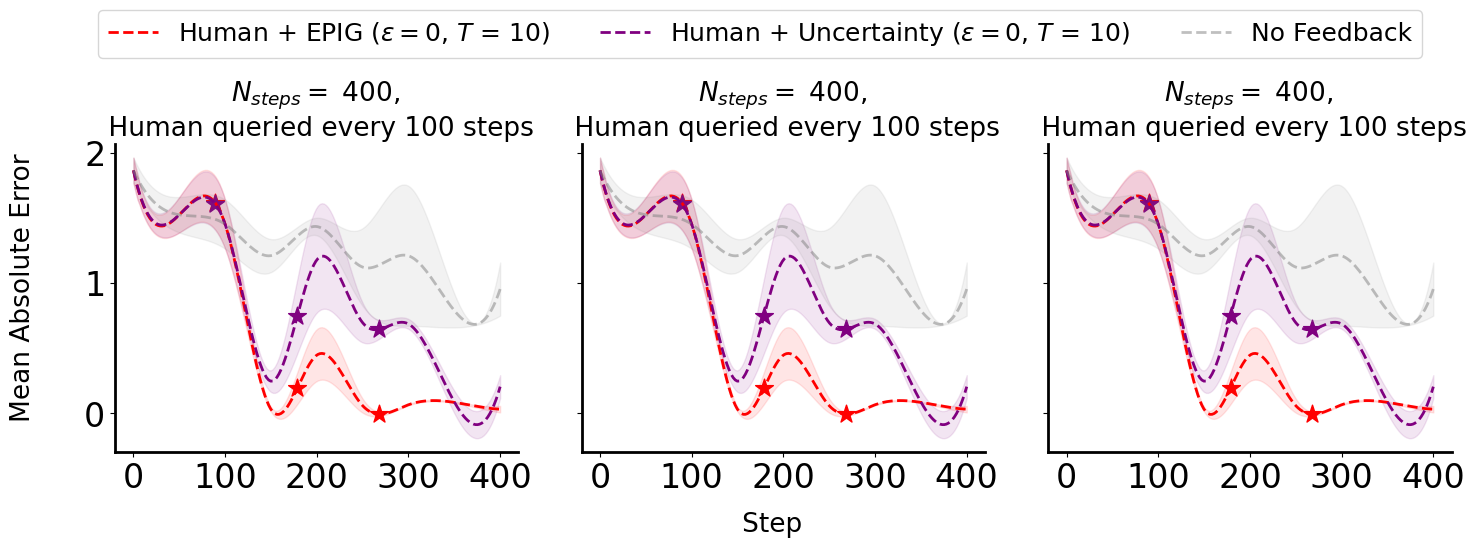

In [79]:
y_label = "Mean Absolute Error"
fig_name = f"{demos}/data_for_figures/LogP_Generalization.svg"

def combine_plots(y_label=y_label, fig_name=fig_name):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=True)

    # Call each plot function with its respective axis
    # Example:
    plot_results("logp_results", R = 4, T = 5, seeds = [2,3], n_steps = 100, acqs = ["epig", "uncertainty"], n_queries = 10, sigma_noise = float(0), cubic=True, ax=axes[0])
    plot_results("logp_results", R = 4, T = 5, seeds = [2,3], n_steps = 100, acqs = ["epig", "uncertainty"], n_queries = 10, sigma_noise = float(1), cubic=True, ax=axes[1])
    plot_results("logp_results", R = 4, T = 5, seeds = [2,3], n_steps = 100, acqs = ["epig", "uncertainty"], n_queries = 10, sigma_noise = float(5), cubic=True, ax=axes[2])
    
    # Add a common legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.08), fontsize=18)
    
    # Add common x and y labels
    fig.text(0.5, 0.01, '   Step', ha='center', fontsize=19)
    fig.text(0, 0.5, y_label, va='center', rotation='vertical', fontsize=19)

    # Show the plots
    fig.tight_layout()
    plt.savefig(fig_name, transparent=True, dpi=300, bbox_inches="tight")
    plt.show()

combine_plots()

/home/klgx638/miniconda3/envs/reinvent.v3.2/lib/python3.7/site-packages/ipykernel_launcher.py:291: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/klgx638/miniconda3/envs/reinvent.v3.2/lib/python3.7/site-packages/ipykernel_launcher.py:292: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/klgx638/miniconda3/envs/reinvent.v3.2/lib/python3.7/site-packages/ipykernel_launcher.py:421: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is d

epig
MAE 0.03171828267034971 0.025112874567098098 
Oracle 2.8985801597373286 0.04179048305767896 
Internal Div 0.837805953326049 0.0019136863127654502 
Internal Div 0.837805953326049 0.0019136863127654502
SA 2.4387384375793437 0.0769850578326059 
QED 0.4074843290177116 0.010712777742316021 
Novelty 1.0 0.0 
Frag Train 0.8576361589687993 0.004067132999396761 
SNN Train 0.29661934527455924 0.005429360381660114 
FCD Train 24.94241461031185 2.1003630432202343 
Frag Queries 0.8095320157974091 0.01925150713654572
SNN Queries 0.2270410172563179 0.0020004332971522987
FCD Queries 49.45007597087991 1.3811374018728166


MAE 0.952953173894542 0.20390011655052587
Oracle 1.9065905194017145 0.21190048391594862
Internal Div Base 0.8578866921936059 0.006749691766490262
SA 2.7293248141993676 0.04809540005968871
QED 0.512761938749912 0.05667788952883818
Novelty 1.0 0.0
Frag Train 0.8764417959054767 0.0016062617139194768
SNN Train 0.26991783771183464 0.005868849209657606
FCD Train 27.76029655092446 0.3420

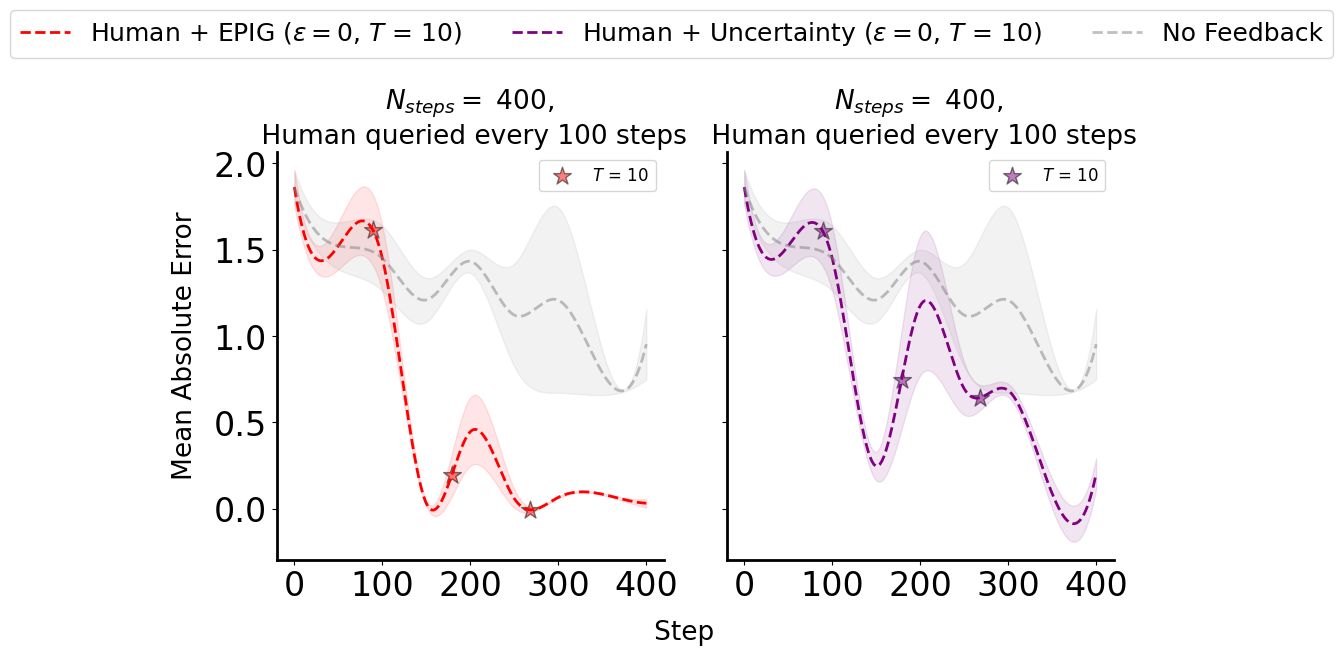

In [97]:
y_label = "Mean Absolute Error"
fig_name = f"{demos}/data_for_figures/LogP_nQueries_Generalization.svg"

# Example with:
acquisitions = ["epig", "uncertainty"]
all_n_queries = [10]

def combine_plots(y_label=y_label, acquisitions=acquisitions, all_n_queries=all_n_queries, fig_name=fig_name):
    fig, axes = plt.subplots(1, len(acquisitions), figsize=(10, 6), sharex=False, sharey=True)
    for i, acq in enumerate(acquisitions):
        for n_queries in all_n_queries:
            # Call each plot function with its respective axis
            plot_results(
                "logp_results", 
                R = 4, 
                T = 5, 
                seeds = [2,3], 
                n_steps = 100, 
                acqs = [acq], 
                n_queries = n_queries, 
                sigma_noise = float(0),
                per_n_queries = True,
                cubic = True, 
                ax = axes[i]
            )
 
    # Add a common legend
    handles, labels = [], []
    for i in range(len(acquisitions)):
        axes[i].legend([
                axes[i].get_legend_handles_labels()[0][1],
                #axes[i].get_legend_handles_labels()[0][4], #to remove legend box duplicates
                #axes[i].get_legend_handles_labels()[0][7]
            ], 
            [
                axes[i].get_legend_handles_labels()[1][1],
                #axes[i].get_legend_handles_labels()[1][4],
                #axes[i].get_legend_handles_labels()[1][7]
            ], fontsize=12)
        handles.append(axes[i].get_legend_handles_labels()[0][0])
        labels.append(axes[i].get_legend_handles_labels()[1][0])
    
    handles.append(axes[i].get_legend_handles_labels()[0][-1])
    labels.append(axes[i].get_legend_handles_labels()[1][-1])
    
    fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.08), fontsize=18)
    
    fig.text(0.5, 0.01, '   Step', ha='center', fontsize=19)
    fig.text(0, 0.5, y_label, va='center', rotation='vertical', fontsize=19)

    fig.tight_layout()
    plt.savefig(fig_name, transparent=True, dpi=300, bbox_inches="tight")
    plt.show()

combine_plots()

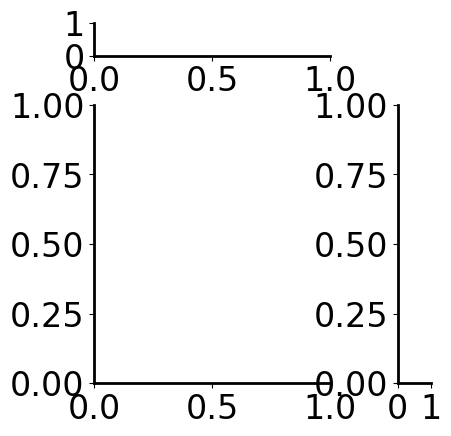

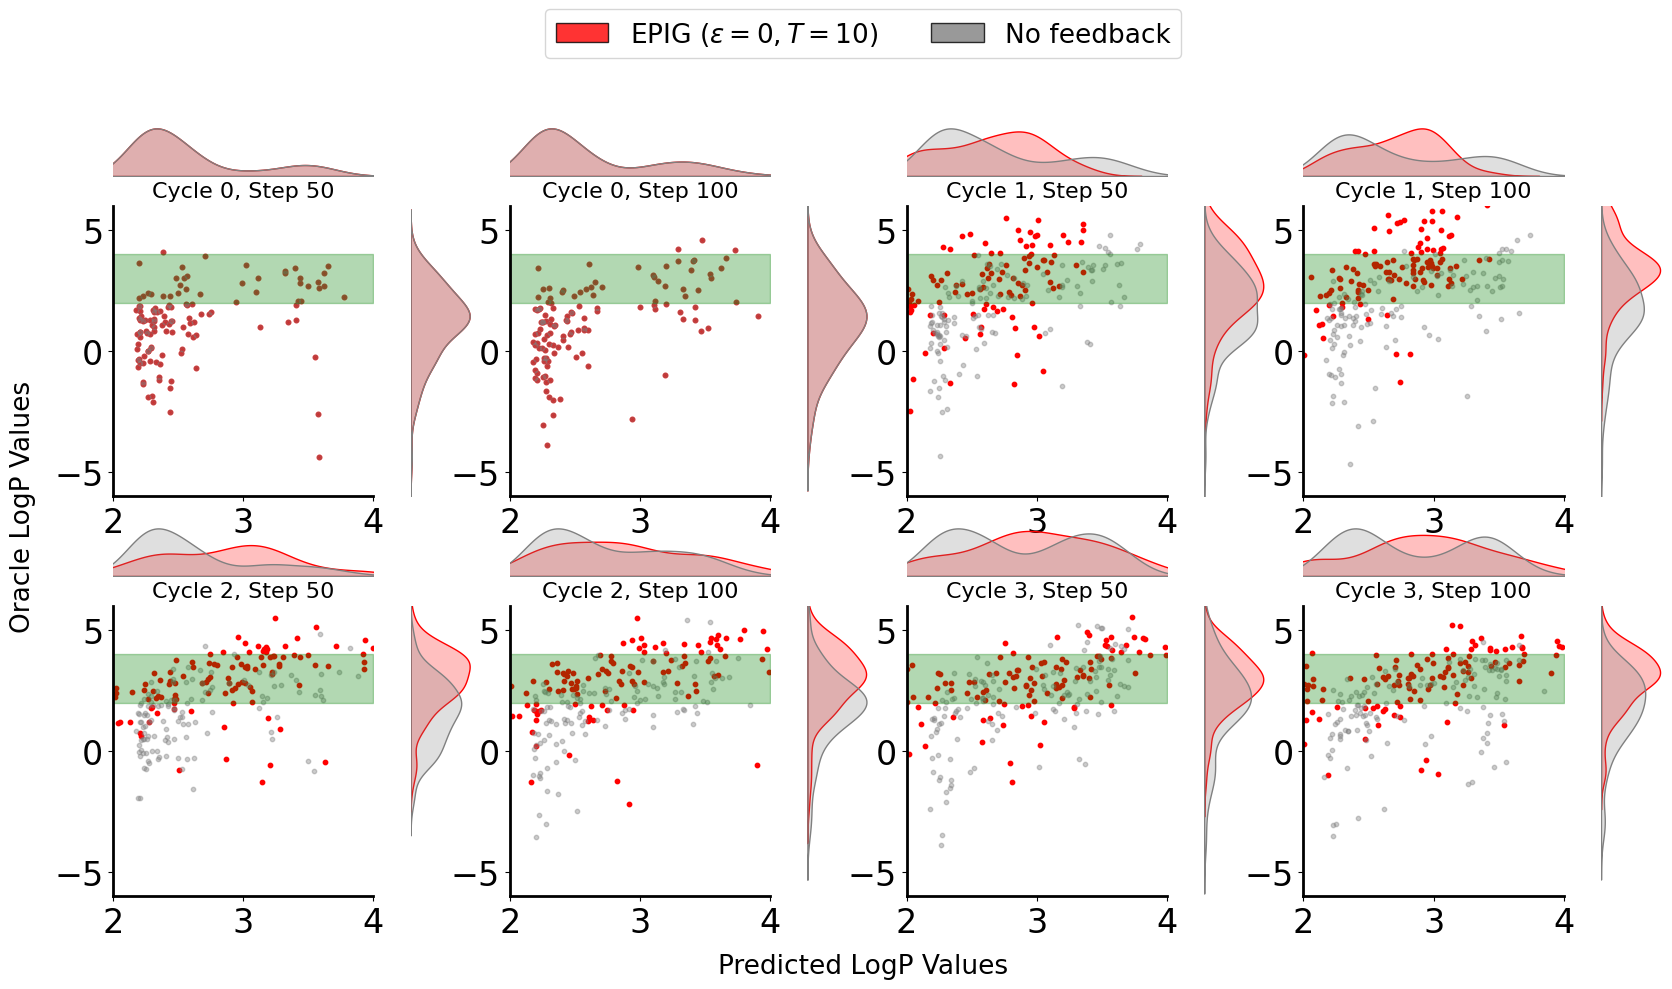

In [107]:
#Example with:
n_steps = 100
res_base_to_check = pickle.load(open(f"{demos}/data_for_figures/logp_results_R4_Steps100_base_seed3.pkl", "rb"))
res_to_check_noisefree = pickle.load(open(f"{demos}/data_for_figures/logp_results_R4_Steps100_T5_n10_epig_noise0.0_seed3.pkl", "rb"))
res_to_check_modnoise = pickle.load(open(f"{demos}/data_for_figures/logp_results_R4_Steps100_T5_n10_epig_noise1.0_seed3.pkl", "rb"))
res_to_check_highnoise = pickle.load(open(f"{demos}/data_for_figures/logp_results_R4_Steps100_T5_n10_epig_noise5.0_seed3.pkl", "rb"))

def plot_oracle_vs_pred(cycle, step, ax_main, ax_x_hist, ax_y_hist, top):
    # Extracting the relevant data from the dictionaries
    predicted_values_noisefree = res_to_check_noisefree["scaffold_memory"][f"all_predicted_values_{top}"][f"cycle{cycle}_step{step}"]
    oracle_values_noisefree = res_to_check_noisefree["scaffold_memory"][f"all_oracle_values_{top}"][f"cycle{cycle}_step{step}"]
    
    predicted_values_modnoise = res_to_check_modnoise["scaffold_memory"][f"all_predicted_values_{top}"][f"cycle{cycle}_step{step}"]
    oracle_values_modnoise = res_to_check_modnoise["scaffold_memory"][f"all_oracle_values_{top}"][f"cycle{cycle}_step{step}"]
    
    predicted_values_highnoise = res_to_check_highnoise["scaffold_memory"][f"all_predicted_values_{top}"][f"cycle{cycle}_step{step}"]
    oracle_values_highnoise = res_to_check_highnoise["scaffold_memory"][f"all_oracle_values_{top}"][f"cycle{cycle}_step{step}"]
    
    predicted_values_base = res_base_to_check["scaffold_memory"][f"all_predicted_values_{top}"][f"cycle{cycle}_step{step}"]
    oracle_values_base = res_base_to_check["scaffold_memory"][f"all_oracle_values_{top}"][f"cycle{cycle}_step{step}"]

    mini, maxi = np.min(predicted_values_base), np.max(predicted_values_base)
    
    oracle_scores_above_min5_noisefree = []
    oracle_scores_above_min5_modnoise = []
    oracle_scores_above_min5_highnoise = []
    pred_scores_above_min5_noisefree = []
    pred_scores_above_min5_modnoise = []
    pred_scores_above_min5_highnoise = []
    oracle_scores_above_min5_base = []
    pred_scores_above_min5_base = []

    for i in range(len(predicted_values_noisefree)):
        if oracle_values_noisefree[i] > -5:
            oracle_scores_above_min5_noisefree.append(oracle_values_noisefree[i])
            pred_scores_above_min5_noisefree.append(predicted_values_noisefree[i])
    
    for i in range(len(predicted_values_modnoise)):
        if oracle_values_modnoise[i] > -5:
            oracle_scores_above_min5_modnoise.append(oracle_values_modnoise[i])
            pred_scores_above_min5_modnoise.append(predicted_values_modnoise[i])
    
    for i in range(len(predicted_values_highnoise)):
        if oracle_values_highnoise[i] > -5:
            oracle_scores_above_min5_highnoise.append(oracle_values_highnoise[i])
            pred_scores_above_min5_highnoise.append(predicted_values_highnoise[i])
            
    for i in range(len(predicted_values_base)):
        if oracle_values_base[i] > -5:
            oracle_scores_above_min5_base.append(oracle_values_base[i])
            pred_scores_above_min5_base.append(predicted_values_base[i])

    # Scatter plot in the provided axis
    ax_main.scatter(pred_scores_above_min5_noisefree, oracle_scores_above_min5_noisefree, color="red", label="EPIG ($\epsilon = 0, T=10$)", s=10)
    ax_main.scatter(pred_scores_above_min5_modnoise, oracle_scores_above_min5_modnoise, color="#FF6666", label="EPIG ($\sigma_{\epsilon} = 1.0, T=10$)", s=10)
    ax_main.scatter(pred_scores_above_min5_highnoise, oracle_scores_above_min5_highnoise, color="#8B0000", label="EPIG ($\sigma_{\epsilon} = 5.0, T=10$)", s=10)
    ax_main.scatter(pred_scores_above_min5_base, oracle_scores_above_min5_base, color="gray", label="No feedback", s=10, alpha=0.4)
    
    # Highlight the area between y=2 and y=4
    ax_main.fill_betweenx([2, 4], 2, 4, color='green', alpha=0.3)
    
    ax_main.set_ylim(-6, 6)
    ax_main.set_xlim(2,4)

    # KDE plot for x-axis on top
    sns.kdeplot(pred_scores_above_min5_noisefree, fill=True, color="red", ax=ax_x_hist)
    sns.kdeplot(pred_scores_above_min5_modnoise, fill=True, color="#FF6666", ax=ax_x_hist)
    sns.kdeplot(pred_scores_above_min5_highnoise, fill=True, color="#8B0000", ax=ax_x_hist)
    sns.kdeplot(pred_scores_above_min5_base, fill=True, color="gray", ax=ax_x_hist)
    ax_x_hist.axis('off')

    # KDE plot for y-axis on the right
    sns.kdeplot(y=oracle_scores_above_min5_noisefree, fill=True, color="red", ax=ax_y_hist, legend=r'Human AL ($\epsilon = 0, T=10$)')
    sns.kdeplot(y=oracle_scores_above_min5_modnoise, fill=True, color="#FF6666", ax=ax_y_hist, legend=r'Human AL ($\sigma_{\epsilon} = 1.0, T=10$)')
    sns.kdeplot(y=oracle_scores_above_min5_highnoise, fill=True, color="#8B0000", ax=ax_y_hist, legend=r'Human AL ($\sigma_{\epsilon} = 5.0, T=10$)')
    sns.kdeplot(y=oracle_scores_above_min5_base, fill=True, color="gray", ax=ax_y_hist, legend='No feedback')
    ax_y_hist.axis('off')
    ax_y_hist.yaxis.tick_right()
    ax_y_hist.yaxis.set_label_position("right")

# Create a figure and a grid of subplots
fig = plt.figure(figsize=(20, 10))
grid = plt.GridSpec(10, 16, hspace=0.6, wspace=0.6)

# Define cycles and steps for each subplot
subplot_configs = [
    (0, 50), (0, n_steps), (1, 50), (1, n_steps),
    (2, 50), (2, n_steps), (3, 50), (3, n_steps)
]

for idx, (cycle, step) in enumerate(subplot_configs):
    row = idx // 4
    col = idx % 4
    main_ax = fig.add_subplot(grid[row*5+1:row*5+5, col*4:col*4+3])
    x_hist_ax = fig.add_subplot(grid[row*5, col*4:col*4+3], sharex=main_ax)
    y_hist_ax = fig.add_subplot(grid[row*5+1:row*5+5, col*4+3], sharey=main_ax)
    
    plot_oracle_vs_pred(cycle, step, main_ax, x_hist_ax, y_hist_ax, "above05")
    main_ax.set_title(f'Cycle {cycle}, Step {step}', fontsize=16)
    
# Add a common legend
handles, labels = main_ax.get_legend_handles_labels()
custom_handles = [Patch(facecolor=handle.get_facecolor()[0], edgecolor='black', alpha=0.8) for handle in handles]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.01), fontsize=19)

fig.text(0.5, 0.04, 'Predicted LogP Values', ha='center', va='center', fontsize=19)
fig.text(0.08, 0.5, 'Oracle LogP Values', ha='center', va='center', rotation='vertical', fontsize=19)

# Show the plots
#fig.tight_layout()
plt.savefig(f"{demos}/data_for_figures/LogP_Distribution.svg", transparent=True, dpi=300, bbox_inches="tight")
plt.show()

/home/klgx638/miniconda3/envs/reinvent.v3.2/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/klgx638/miniconda3/envs/reinvent.v3.2/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/klgx638/miniconda3/envs/reinvent.v3.2/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/klgx638/miniconda3/envs/reinvent.v3.2/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


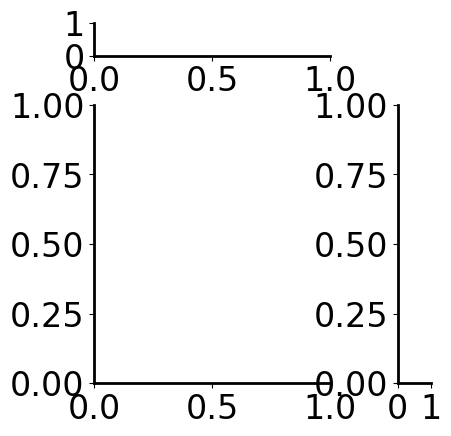

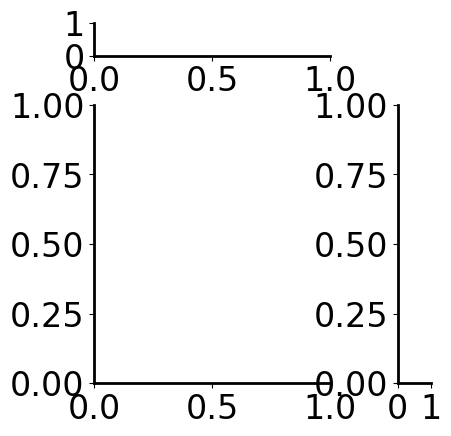

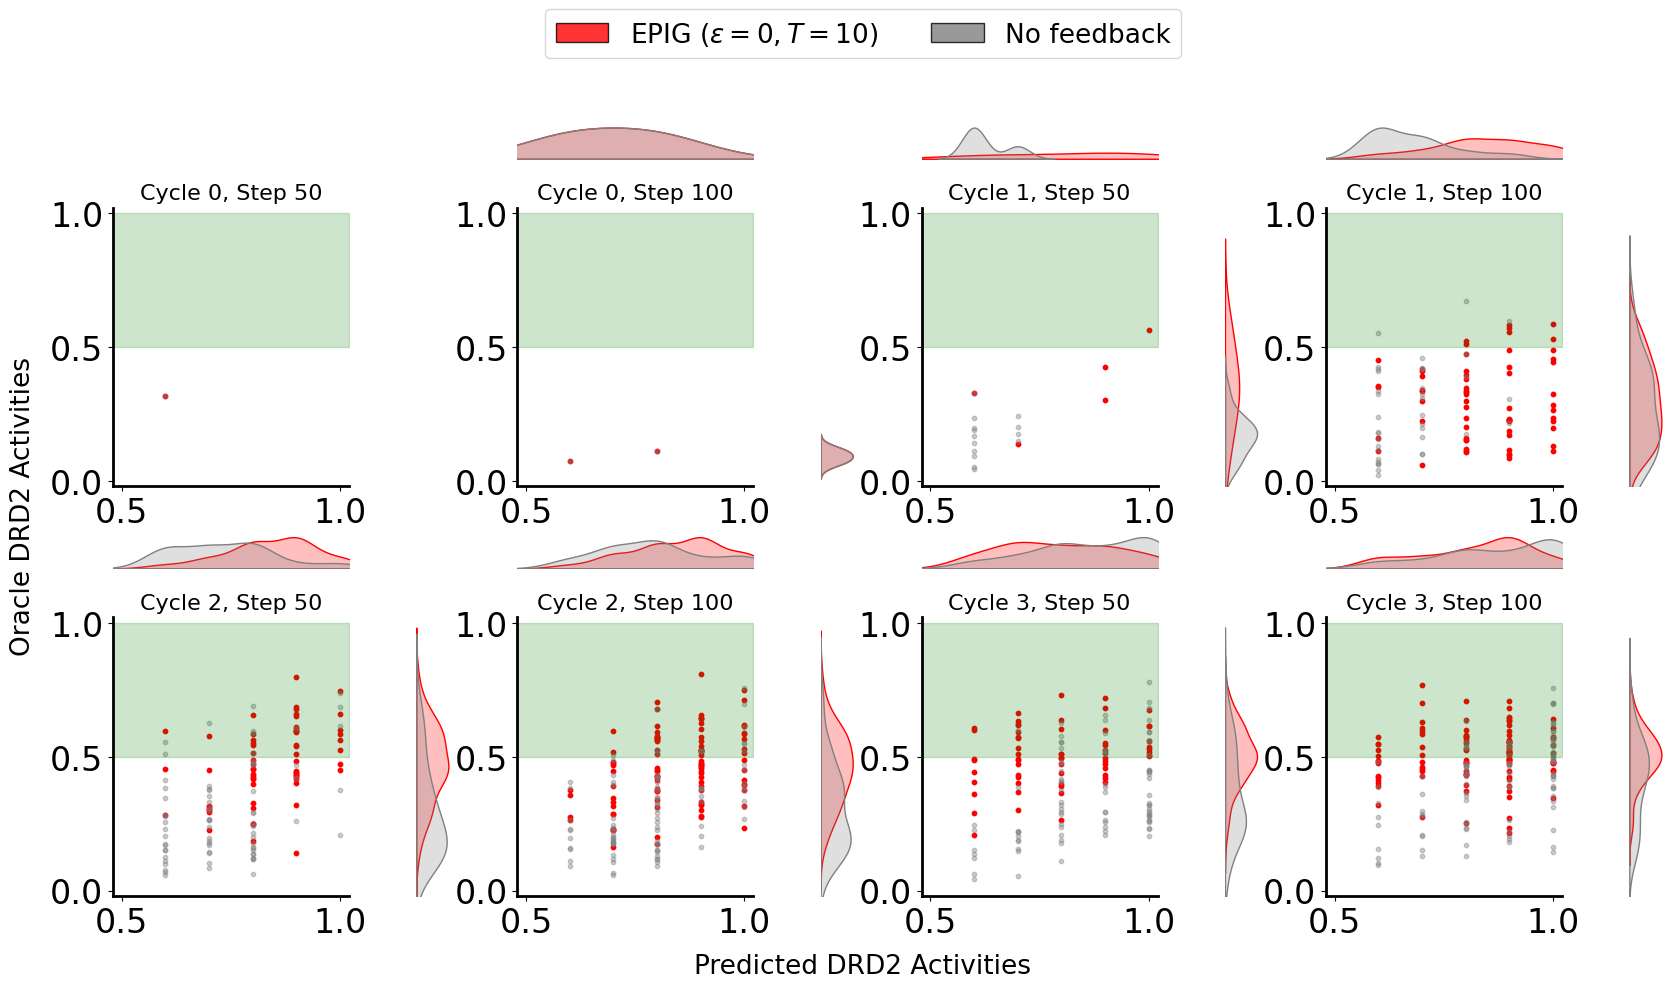

In [120]:
#Example with:
n_steps = 250
res_base_to_check = pickle.load(open(f"{demos}/data_for_figures/drd2_results_R4_Steps{n_steps}_base_seed2.pkl", "rb"))
res_to_check_noisefree = pickle.load(open(f"{demos}/data_for_figures/drd2_results_R4_Steps{n_steps}_T5_n10_epig_noise0.0_seed2.pkl", "rb"))
res_to_check_modnoise = pickle.load(open(f"{demos}/data_for_figures/drd2_results_R4_Steps{n_steps}_T5_n10_epig_noise0.15_seed2.pkl", "rb"))
res_to_check_highnoise = pickle.load(open(f"{demos}/data_for_figures/drd2_results_R4_Steps{n_steps}_T5_n10_epig_noise0.3_seed2.pkl", "rb"))

def plot_oracle_vs_pred(cycle, step, ax_main, ax_x_hist, ax_y_hist, top):
    # Extracting the relevant data from the dictionaries
    predicted_values_noisefree = res_to_check_noisefree["scaffold_memory"][f"all_predicted_values_{top}"][f"cycle{cycle}_step{step}"]
    oracle_values_noisefree = res_to_check_noisefree["scaffold_memory"][f"all_oracle_values_{top}"][f"cycle{cycle}_step{step}"]
    predicted_values_modnoise = res_to_check_modnoise["scaffold_memory"][f"all_predicted_values_{top}"][f"cycle{cycle}_step{step}"]
    oracle_values_modnoise = res_to_check_modnoise["scaffold_memory"][f"all_oracle_values_{top}"][f"cycle{cycle}_step{step}"]
    predicted_values_highnoise = res_to_check_highnoise["scaffold_memory"][f"all_predicted_values_{top}"][f"cycle{cycle}_step{step}"]
    oracle_values_highnoise = res_to_check_highnoise["scaffold_memory"][f"all_oracle_values_{top}"][f"cycle{cycle}_step{step}"]
    predicted_values_base = res_base_to_check["scaffold_memory"][f"all_predicted_values_{top}"][f"cycle{cycle}_step{step}"]
    oracle_values_base = res_base_to_check["scaffold_memory"][f"all_oracle_values_{top}"][f"cycle{cycle}_step{step}"]

    mini, maxi = np.min(predicted_values_base), np.max(predicted_values_base)
    
    oracle_scores_above_min5_noisefree = []
    oracle_scores_above_min5_modnoise = []
    oracle_scores_above_min5_highnoise = []
    pred_scores_above_min5_noisefree = []
    pred_scores_above_min5_modnoise = []
    pred_scores_above_min5_highnoise = []
    oracle_scores_above_min5_base = []
    pred_scores_above_min5_base = []

    for i in range(len(predicted_values_noisefree)):
        if oracle_values_noisefree[i] > -5:
            oracle_scores_above_min5_noisefree.append(oracle_values_noisefree[i])
            pred_scores_above_min5_noisefree.append(predicted_values_noisefree[i])
   
    for i in range(len(predicted_values_modnoise)):
        if oracle_values_modnoise[i] > -5:
            oracle_scores_above_min5_modnoise.append(oracle_values_modnoise[i])
            pred_scores_above_min5_modnoise.append(predicted_values_modnoise[i])
    
    for i in range(len(predicted_values_highnoise)):
        if oracle_values_highnoise[i] > -5:
            oracle_scores_above_min5_highnoise.append(oracle_values_highnoise[i])
            pred_scores_above_min5_highnoise.append(predicted_values_highnoise[i])
            
    for i in range(len(predicted_values_base)):
        if oracle_values_base[i] > -5:
            oracle_scores_above_min5_base.append(oracle_values_base[i])
            pred_scores_above_min5_base.append(predicted_values_base[i])

    # Scatter plot in the provided axis
    ax_main.scatter(pred_scores_above_min5_noisefree, oracle_scores_above_min5_noisefree, color="red", label=r"EPIG ($\epsilon = 0, T=10$)", s=10)
    ax_main.scatter(pred_scores_above_min5_modnoise, oracle_scores_above_min5_modnoise, color="#FF6666", label=r"EPIG ($\sigma_{\epsilon} = 0.15, T=10$)", s=10)
    ax_main.scatter(pred_scores_above_min5_highnoise, oracle_scores_above_min5_highnoise, color="#8B0000", label=r"EPIG ($\sigma_{\epsilon} = 0.3, T=10$)", s=10)
    ax_main.scatter(pred_scores_above_min5_base, oracle_scores_above_min5_base, color="gray", label="No feedback", s=10, alpha=0.4)
    
    # Highlight the area between y=2 and y=4
    ax_main.fill_betweenx([0.5, 1], 0.48, 1.02, color='green', alpha=0.2)
    
    ax_main.set_ylim(-0.02, 1.02)
    ax_main.set_xlim(0.48, 1.02)

    # KDE plot for x-axis on top
    sns.kdeplot(pred_scores_above_min5_noisefree, fill=True, color="red", ax=ax_x_hist)
    sns.kdeplot(pred_scores_above_min5_modnoise, fill=True, color="#FF6666", ax=ax_x_hist)
    sns.kdeplot(pred_scores_above_min5_highnoise, fill=True, color="#8B0000", ax=ax_x_hist)
    sns.kdeplot(pred_scores_above_min5_base, fill=True, color="gray", ax=ax_x_hist)
    ax_x_hist.axis('off')

    # KDE plot for y-axis on the right
    sns.kdeplot(y=oracle_scores_above_min5_noisefree, fill=True, color="red", ax=ax_y_hist, legend=r'Human AL ($\epsilon = 0, T=10$)')
    sns.kdeplot(y=oracle_scores_above_min5_modnoise, fill=True, color="#FF6666", ax=ax_y_hist, legend=r'Human AL ($\sigma_{\epsilon} = 1.0, T=10$)')
    sns.kdeplot(y=oracle_scores_above_min5_highnoise, fill=True, color="#8B0000", ax=ax_y_hist, legend=r'Human AL ($\sigma_{\epsilon} = 5.0, T=10$)')
    sns.kdeplot(y=oracle_scores_above_min5_base, fill=True, color="gray", ax=ax_y_hist, legend='No feedback')
    ax_y_hist.axis('off')
    ax_y_hist.yaxis.tick_right()
    ax_y_hist.yaxis.set_label_position("right")

# Create a figure and a grid of subplots
fig = plt.figure(figsize=(20, 10))
grid = plt.GridSpec(10, 16, hspace=1.5, wspace=2)

# Define cycles and steps for each subplot
subplot_configs = [
    (0, 50), (0, n_steps), (1, 50), (1, n_steps),
    (2, 50), (2, n_steps), (3, 50), (3, n_steps)
]

for idx, (cycle, step) in enumerate(subplot_configs):
    row = idx // 4
    col = idx % 4
    main_ax = fig.add_subplot(grid[row*5+1:row*5+5, col*4:col*4+3])
    x_hist_ax = fig.add_subplot(grid[row*5, col*4:col*4+3], sharex=main_ax)
    y_hist_ax = fig.add_subplot(grid[row*5+1:row*5+5, col*4+3], sharey=main_ax)
    
    plot_oracle_vs_pred(cycle, step, main_ax, x_hist_ax, y_hist_ax, "above05")
    main_ax.set_title(f'Cycle {cycle}, Step {step}', fontsize=16)
    
# Add a common legend
handles, labels = main_ax.get_legend_handles_labels()
custom_handles = [Patch(facecolor=handle.get_facecolor()[0], edgecolor='black', alpha=0.8) for handle in handles]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.01), fontsize=19)
#fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.01), fontsize=19)

# Shared x and y axis labels
fig.text(0.5, 0.04, 'Predicted DRD2 Activities', ha='center', va='center', fontsize=19)
fig.text(0.08, 0.5, 'Oracle DRD2 Activities', ha='center', va='center', rotation='vertical', fontsize=19)

# Show the plots
#fig.tight_layout()
plt.savefig(f"{demos}/data_for_figures/DRD2_Distribution.svg", transparent=True, dpi=300, bbox_inches="tight")
plt.show()

### Statistic analysis of result significance

In [123]:
def anova_test_multiple_methods(method_results, baseline_results, alpha=0.05, alpha_01=0.01):
    """
    Perform a one-way ANOVA test between multiple methods and baseline results.

    Parameters:
    method_results (dict of arrays): A dictionary containing results for multiple methods across replicates.
    baseline_results (array): An array containing results for the baseline.
    alpha (float): Significance level for p-value 0.05.
    alpha_01 (float): Significance level for p-value 0.01.

    Returns:
    dict: A dictionary indicating if each method's results are significant at 0.05 and 0.01 levels,
          and whether each method is better or worse than the baseline.
    """
    results = {}

    for method_name, method_data in method_results.items():
        f_stat, p_val = f_oneway(method_data, baseline_results)

        is_significant_at_05 = p_val < alpha
        is_significant_at_01 = p_val < alpha_01

        mean_method = np.mean(method_data)
        mean_baseline = np.mean(baseline_results)

        if mean_method > mean_baseline:
            comparison = "higher than baseline"
        else:
            comparison = "lower than baseline"

        results[method_name] = {
            "p_val": p_val,
            "significant_at_05": is_significant_at_05,
            "significant_at_01": is_significant_at_01,
            "comparison": comparison
        }
    
    return results

def signif_outcome(res):
    if res["significant_at_01"]:
        signif = "**"
    elif res["significant_at_05"]:
        signif = "*"
    else:
        signif = ""
    return signif, res["comparison"]

In [130]:
#Example with:
n_steps = 100
seeds = [2,3]
drd2_or_logp = "logp"
multi = False

n_molecules_last_step_base = []
mae_base = []
int_div_base = []
sa_base, qed_base, novel_base, unique_base = [], [], [], []
snn_train_base, frag_train_base, fcd_train_base = [], [], []
snn_queries_base, frag_queries_base, fcd_queries_base = [], [], []

if drd2_or_logp == "logp":
    score_component_name = "logp"
    feedback_model = EvaluationModel("logp")
    path_to_results = f"{demos}/demo_logp_R4_step100_None"
    train_set_actives = pd.read_csv(f"{training}/penal_logp_train.csv")
else:
    score_component_name = "bioactivity"
    feedback_model = EvaluationModel("drd2", f"{simulators}/drd2.pkl")
    path_to_results = f"{demos}/demo_drd2_R4_step100_None"
    train_set = pd.read_csv(f"{training}/drd2_train.csv")
    train_set_actives = train_set[train_set["target"] == 1]
    if multi:
        path_to_results = f"{demos}/demo_drd2_multi_R4_step100_None"

for seed in seeds:
        
    try:
        results_scaff_acq = pd.read_csv(f"{path_to_results}_seed{seed}/iteration3/results/scaffold_memory.csv")
        results_scaff_acq = results_scaff_acq[results_scaff_acq[score_component_name] > 0.5]
        #queries_set = pd.read_csv(f"{path_to_results}_seed{seed}/iteration3/augmented_train_set_iter4.csv")
        #queries_set = queries_set.SMILES.tolist()[-50:]
        n_molecules_last_step_base.append(len(results_scaff_acq[results_scaff_acq["Step"] == n_steps-1]))
        last_step_mols = results_scaff_acq[results_scaff_acq["Step"] == n_steps-1]
        
        mae_base.append(mean_absolute_error([feedback_model.oracle_score(s) for s in last_step_mols.SMILES.tolist()], last_step_mols[f"raw_{score_component_name}"].values.tolist()))
        int_div_base.append(internal_diversity(last_step_mols.SMILES.tolist()))
        sa_base.append(np.mean([SA(Chem.MolFromSmiles(s)) for s in last_step_mols.SMILES.tolist()]))
        qed_base.append(np.mean([QED(Chem.MolFromSmiles(s)) for s in last_step_mols.SMILES.tolist()]))
        unique_base.append(fraction_unique(last_step_mols.SMILES.tolist()))
        novel_base.append(novelty(last_step_mols.SMILES.tolist(), train_set_actives.SMILES.tolist()))
        snn_train_base.append(get_pairwise_structural_metrics(last_step_mols.SMILES.tolist(), train_set_actives.SMILES.tolist(), "snn"))
        frag_train_base.append(get_pairwise_structural_metrics(last_step_mols.SMILES.tolist(), train_set_actives.SMILES.tolist(), "frag"))
        fcd_train_base.append(get_pairwise_structural_metrics(last_step_mols.SMILES.tolist(), train_set_actives.SMILES.tolist(), "fcd"))
    except:
        pass

100%|██████████████████████████████████████████████████████████| 9.05M/9.05M [00:10<00:00, 824kiB/s]
Done!


In [134]:
#Example with:
acqs = ["epig", "uncertainty"]
n_steps = 100
seeds = [2,3]
drd2_or_logp = "logp"
multi = False

n_molecules_last_step = {}
mae = {}
int_div = {}
sa, qed, novel, unique = {}, {}, {}, {}
snn_train, frag_train, fcd_train = {}, {}, {}
snn_queries, frag_queries, fcd_queries = {}, {}, {}

if drd2_or_logp == "logp":
    path_to_results = f"{demos}/demo_logp_R4_step{n_steps}_T5_n10"
    noise = float(0)
    score_component_name = "logp"
else:
    path_to_results = f"{demos}/demo_drd2_R4_step{n_steps}_T5_n10"
    acqs = ["epig", "entropy"]
    noise = float(0)
    score_component_name = "bioactivity"
    if multi:
        path_to_results = f"{demos}/demo_drd2_multi_R4_step{n_steps}_T5_n10"


for acq in acqs:
    
    n_molecules_last_step[acq] = []
    mae[acq] = []
    int_div[acq] = []
    sa[acq], qed[acq], unique[acq], novel[acq], snn_train[acq], frag_train[acq], fcd_train[acq] = [], [], [], [], [], [], []
    snn_queries[acq], frag_queries[acq], fcd_queries[acq] = [], [], []
    
    for seed in seeds:
        
        try:
            results_scaff_acq = pd.read_csv(f"{path_to_results}_{acq}_noise{noise}_seed{seed}/iteration3/results/scaffold_memory.csv")
            results_scaff_acq = results_scaff_acq[results_scaff_acq[score_component_name] > 0.5]
            n_molecules_last_step[acq].append(len(results_scaff_acq[results_scaff_acq["Step"] == n_steps-1]))
            queries_set = pd.read_csv(f"{path_to_results}_{acq}_noise{noise}_seed{seed}/iteration3/augmented_train_set_iter4.csv")
            queries_set = queries_set.SMILES.tolist()[-50:]
            last_step_mols = results_scaff_acq[results_scaff_acq["Step"] == n_steps-1]
            
            mae[acq].append(mean_absolute_error([feedback_model.oracle_score(s) for s in last_step_mols.SMILES.tolist()], last_step_mols[f"raw_{score_component_name}"].values.tolist()))
            int_div[acq].append(internal_diversity(last_step_mols.SMILES.tolist()))
            sa[acq].append(np.mean([SA(Chem.MolFromSmiles(s)) for s in last_step_mols.SMILES.tolist()]))
            qed[acq].append(np.mean([QED(Chem.MolFromSmiles(s)) for s in last_step_mols.SMILES.tolist()]))
            unique[acq].append(fraction_unique(last_step_mols.SMILES.tolist()))
            novel[acq].append(novelty(last_step_mols.SMILES.tolist(), train_set_actives.SMILES.tolist()))
            snn_train[acq].append(get_pairwise_structural_metrics(last_step_mols.SMILES.tolist(), train_set_actives.SMILES.tolist(), "snn"))
            frag_train[acq].append(get_pairwise_structural_metrics(last_step_mols.SMILES.tolist(), train_set_actives.SMILES.tolist(), "frag"))
            fcd_train[acq].append(get_pairwise_structural_metrics(last_step_mols.SMILES.tolist(), train_set_actives.SMILES.tolist(), "fcd"))
            snn_queries[acq].append(get_pairwise_structural_metrics(last_step_mols.SMILES.tolist(), queries_set, "snn"))
            frag_queries[acq].append(get_pairwise_structural_metrics(last_step_mols.SMILES.tolist(), queries_set, "frag"))
            fcd_queries[acq].append(get_pairwise_structural_metrics(last_step_mols.SMILES.tolist(), queries_set, "fcd"))
            
        except:
            pass

In [136]:
print("Demo MONO LogP")

mae_signif = anova_test_multiple_methods(mae, mae_base)
int_div_signif = anova_test_multiple_methods(int_div, int_div_base)
sa_signif = anova_test_multiple_methods(sa, sa_base)
qed_signif = anova_test_multiple_methods(qed, qed_base)
snn_train_signif = anova_test_multiple_methods(snn_train, snn_train_base)
frag_train_signif = anova_test_multiple_methods(frag_train, frag_train_base)
fcd_train_signif = anova_test_multiple_methods(fcd_train, fcd_train_base)

print("Base")
print("N molecules", np.mean(n_molecules_last_step_base), np.std(n_molecules_last_step_base))
print("MAE", np.mean(mae_base), np.std(mae_base))
print("IntDiv", np.mean(int_div_base), np.std(int_div_base))
print("SA", np.mean(sa_base), np.std(sa_base))
print("QED", np.mean(qed_base), np.std(qed_base))
print("unique", np.mean(unique_base), np.std(unique_base))
print("novel", np.mean(novel_base), np.std(novel_base))
print("SNN Train", np.mean(snn_train_base), np.std(snn_train_base))
print("Frag Train", np.mean(frag_train_base), np.std(frag_train_base))
print("FCD Train", np.mean(fcd_train_base), np.std(fcd_train_base))
print("\n")

for acq in acqs:
    
    print(acq)
    print("N molecules", np.mean(n_molecules_last_step[acq]), np.std(n_molecules_last_step[acq]))
    print("MAE", np.mean(mae[acq]), np.std(mae[acq]), signif_outcome(mae_signif[acq]))
    print("IntDiv", np.mean(int_div[acq]), np.std(int_div[acq]), signif_outcome(int_div_signif[acq]))
    print("SA", np.mean(sa[acq]), np.std(sa[acq]), signif_outcome(sa_signif[acq]))
    print("QED", np.mean(qed[acq]), np.std(qed[acq]), signif_outcome(qed_signif[acq]))
    print("unique", np.mean(unique[acq]), np.std(unique[acq]))
    print("novel", np.mean(novel[acq]), np.std(novel[acq]))
    print("SNN Train", np.mean(snn_train[acq]), np.std(snn_train[acq]), signif_outcome(snn_train_signif[acq]))
    print("Frag Train", np.mean(frag_train[acq]), np.std(frag_train[acq]), signif_outcome(frag_train_signif[acq]))
    print("FCD Train", np.mean(fcd_train[acq]), np.std(fcd_train[acq]), signif_outcome(fcd_train_signif[acq]))
    print("SNN Queries", np.mean(snn_queries[acq]), np.std(snn_queries[acq]))
    print("Frag Queries", np.mean(frag_queries[acq]), np.std(frag_queries[acq]))
    print("FCD Queries", np.mean(fcd_queries[acq]), np.std(fcd_queries[acq]))
    print("\n")

Demo MONO LogP
Base
N molecules 127.0 1.0
MAE 1.2504804962506926 0.042613331224490736
IntDiv 0.8537834086719531 0.0009106140615049996
SA 2.6855204636024417 0.008596103112738174
QED 0.4697331166287574 0.012946538976545602
unique 1.0 0.0
novel 1.0 0.0
SNN Train 0.26939744823372047 8.547508863673836e-05
Frag Train 0.8692335561183002 0.013036005622508562
FCD Train 27.599863310851863 0.34673454507331414


epig
N molecules 111.0 1.0
MAE 0.8047472786477561 0.04429478899654021 ('*', 'lower than baseline')
IntDiv 0.8367496744207792 0.0024202494246222117 ('*', 'lower than baseline')
SA 2.3810327618587777 0.06009665603653547 ('*', 'lower than baseline')
QED 0.4142793638214445 0.003494151222552061 ('', 'lower than baseline')
unique 1.0 0.0
novel 1.0 0.0
SNN Train 0.3053082419051365 0.005324639887972299 ('*', 'higher than baseline')
Frag Train 0.8611383827577556 0.011774613434807013 ('', 'lower than baseline')
FCD Train 23.901677229633236 0.5471160594497206 ('*', 'lower than baseline')
SNN Queries 

In [140]:
#Example with:
jobname = "logp_results"
n_steps = 100
seeds = [2,3]
sigma_noise = float(0)
acquisitions = ["epig", "uncertainty", "greedy_regression", "random"]
n_queries = 10

mae_by_seed_base = {}
mae_by_seed = {}

for i in seeds:
    try:
        res_base = pickle.load(open(f"{demos}/data_for_figures/{jobname}_R4_Steps{n_steps}_base_seed{i}.pkl", "rb"))
    
        cleaned_scores_pred = list(res_base["scaffold_memory"]["mean_predicted_value_above05"].values())
        cleaned_scores = list(res_base["scaffold_memory"]["mean_oracle_value_above05"].values())
        mae_by_seed_base[i] = np.abs(np.array(cleaned_scores_pred) - np.array(cleaned_scores))
    except:
        pass
    
for acq in acquisitions:
    mae_by_seed[acq] = {}
    for i in seeds:
        try:
            res = pickle.load(open(f"{demos}/data_for_figures/{jobname}_R4_Steps{n_steps}_T5_n{n_queries}_{acq}_noise{sigma_noise}_seed{i}.pkl", "rb"))
            cleaned_scores_pred = list(res["scaffold_memory"]["mean_predicted_value_above05"].values())
            cleaned_scores = list(res["scaffold_memory"]["mean_oracle_value_above05"].values())
            mae_by_seed[acq][i] = np.abs(np.array(cleaned_scores_pred) - np.array(cleaned_scores))
        except:
            pass

In [144]:
# Stack arrays into a 2D array
stacked_values_base = np.stack(list(mae_by_seed_base.values()))
# Calculate the mean across the columns (axis=0)
mean_values_base = np.mean(stacked_values_base, axis=0)

stacked_values_epig = np.stack(list(mae_by_seed["epig"].values()))
mean_values_epig = np.mean(stacked_values_epig, axis=0)

stacked_values_uncertainty = np.stack(list(mae_by_seed["uncertainty"].values()))
mean_values_uncertainty = np.mean(stacked_values_uncertainty, axis=0)

stacked_values_greedy = np.stack(list(mae_by_seed["greedy_regression"].values()))
mean_values_greedy = np.mean(stacked_values_greedy, axis=0)

stacked_values_random = np.stack(list(mae_by_seed["random"].values()))
mean_values_random = np.mean(stacked_values_random, axis=0)

ANOVA result: F_onewayResult(statistic=5.88372928533395, pvalue=0.006525288862276686)
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1     group2   meandiff p-adj   lower   upper  reject
-----------------------------------------------------------
Baseline        Epig  -0.7689 0.0057 -1.3326 -0.2052   True
Baseline Uncertainty  -0.5342 0.0662 -1.0979  0.0295  False
    Epig Uncertainty   0.2347 0.5687  -0.329  0.7984  False
-----------------------------------------------------------


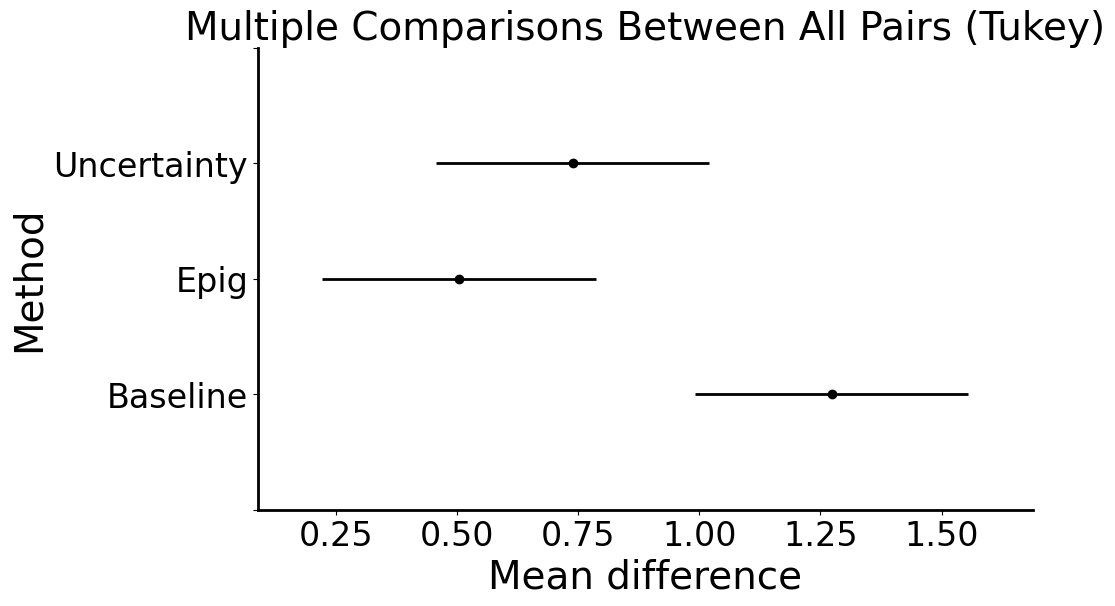

In [148]:
# Example data for five methods
data = {
    'Baseline': mean_values_base,
    'Epig': mean_values_epig,
    'Uncertainty': mean_values_uncertainty,
    'Greedy': mean_values_greedy,
    'Random': mean_values_random
}

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame to long format
df_melt = df.melt(var_name='Method', value_name='Value')

# Perform ANOVA
anova_result = stats.f_oneway(df['Baseline'], df['Epig'], df['Uncertainty'], df['Greedy'], df['Random'])
print('ANOVA result:', anova_result)

# If ANOVA is significant, perform Tukey's HSD test
if anova_result.pvalue < 0.05:
    tukey = pairwise_tukeyhsd(endog=df_melt['Value'], groups=df_melt['Method'], alpha=0.05)
    print(tukey)

    # Plot the results of the Tukey HSD test
    tukey.plot_simultaneous(ylabel='Method', xlabel='Mean difference')
    plt.show()
else:
    print("No significant difference found between the methods.")
